In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2
import math
import random

%matplotlib inline 

## Загрузка шаблона карты

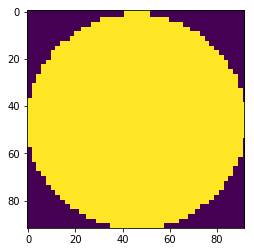

In [7]:
wafer_map = pd.read_pickle('test_wafer_map.pkl')
test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

## проверка
plt.imshow(test);

# Генератор пилообразных прямых 

In [8]:
def sawtooth_line(XC_, YC_, L0_, angle_, line_count, lam_poisson=0.2):
    size = XC_.shape[0]
    fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(40, 40))
    ax = ax.ravel(order='C')
    for n in range(size):   
        # иниицализация параметров прямой
        L0 = L0_[n]
        XC = XC_[n]
        YC = YC_[n]
        angle = angle_[n]
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## параметры уравнения
        def delta_(x,y):
            return int(math.sqrt(x**2 + y**2))
        delta = np.vectorize(delta_)

        L = L0 - np.sum(delta(XC, YC)[1:])
        N = 200
        x0, y0 = 0, 0

        ## кусочное построение пилообразной прямой 
        for i in range(line_count):
            ## случайное удлинение или укорочение отрезка
            import random
            rand = random.randint(-1,0)
            scale = 0.4
            t = np.linspace(0, L//(line_count + rand*scale), N)

            xc = XC[i]
            yc = YC[i]
            X = np.cos(angle[i]) * t + xc + x0
            Y = np.sin(angle[i]) * t + yc + y0
            X_ = np.around(X)
            Y_ = np.around(Y)

            x_prev, y_prev = x0, y0

            for j in range(X_.shape[0]):
                x = int(X_[j])
                y = int(Y_[j])
                if j == 0:
                    ## первая точка прямой 
                    x_first, y_first = x, y

                try:
                    if test[x,y] == 1:
                        test[x,y] = COLOR_SCALE
                        x0, y0 = x, y
                except IndexError:
                    break


            ## сшивка прямых        
            if i != 0:
                ## уравнение прямой сшивки
                k = (y_prev - y_first) / (x_prev - x_first+1e-06)
                b = y_first - k*x_first
                X = np.linspace(x_prev, x_first, 20)
                Y = k * X + b
                X_ = np.around(X)
                Y_ = np.around(Y)
                for j in range(X_.shape[0]):
                    x = int(X_[j])
                    y = int(Y_[j])
                    try:
                        if test[x,y] == 1:
                            test[x,y] = COLOR_SCALE
                    except IndexError:
                        break

        is_dilate = random.randint(-1,1)
        if is_dilate == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            test = cv2.dilate(test,kernel,iterations = 3)
            test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)
            

        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
#         r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        
        is_morph_close = random.randint(0,1)
        if is_morph_close == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)

    
        ax[n].imshow(noise_img, cmap='inferno');
        # plt.savefig('test_noise_1.jpg')
    plt.tight_layout()
    plt.show()

# Генерация кривых

## Пилообразные прямые 

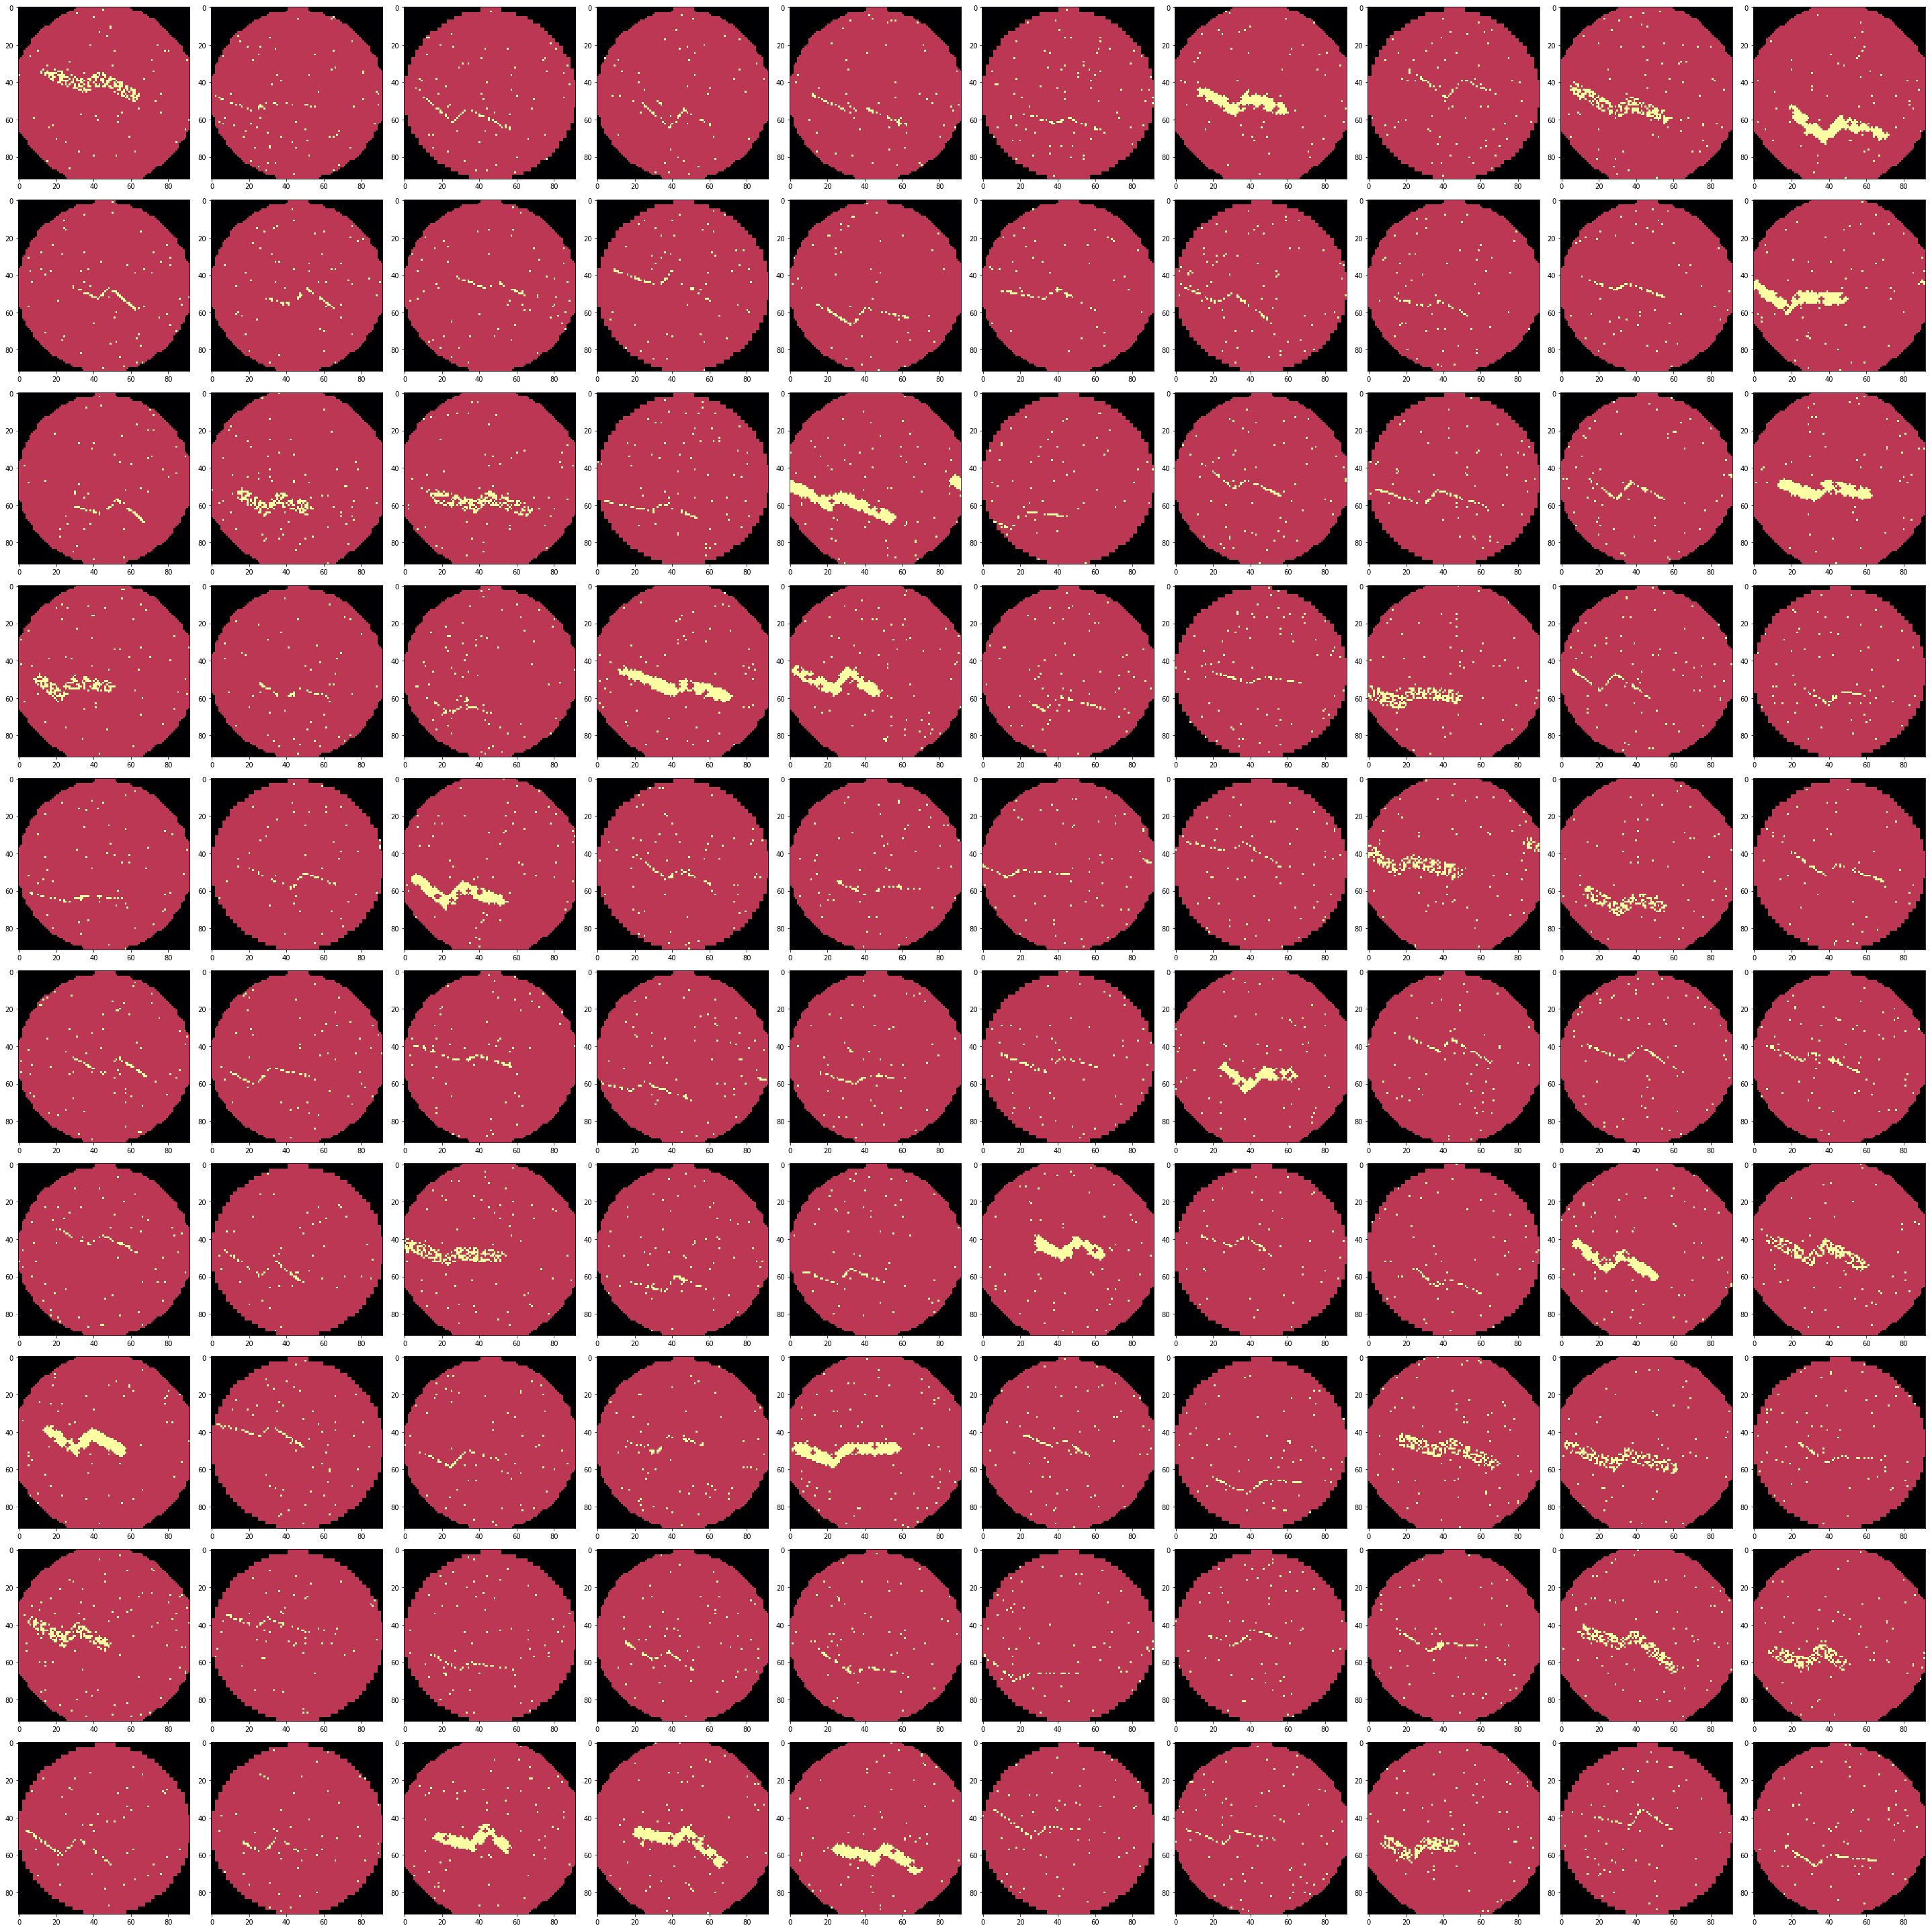

Wall time: 8.05 s


In [9]:
%%time

N_POINT = 100

L0 = np.random.randint(40, 55, size=N_POINT)

XC = np.random.randint(46, 70, size=N_POINT)
delta_xc = np.random.randint(3, 10, size=N_POINT)
np.random.shuffle(delta_xc)
XC = np.vstack((XC, delta_xc))
xc = np.array([[XC[0,i], XC[1,i]] for i in range(XC.shape[1])])

YC = np.random.randint(46, 70, size=N_POINT)
delta_yc = np.random.randint(-8, -5, size=N_POINT)
np.random.shuffle(delta_yc)
YC = np.vstack((YC, delta_yc))
yc = np.array([[YC[0,i], YC[1,i]] for i in range(YC.shape[1])])

angle1 = np.random.randint(-130, -90, size=N_POINT) * np.pi/180
angle2 = np.random.randint(-130, -100, size=N_POINT) * np.pi/180
angle = np.vstack((angle1, angle2))
angle = np.array([[angle[0,i], angle[1,i]] for i in range(angle.shape[1])])

sawtooth_line(xc, yc, L0, angle, line_count=2)

## Прмые линии 

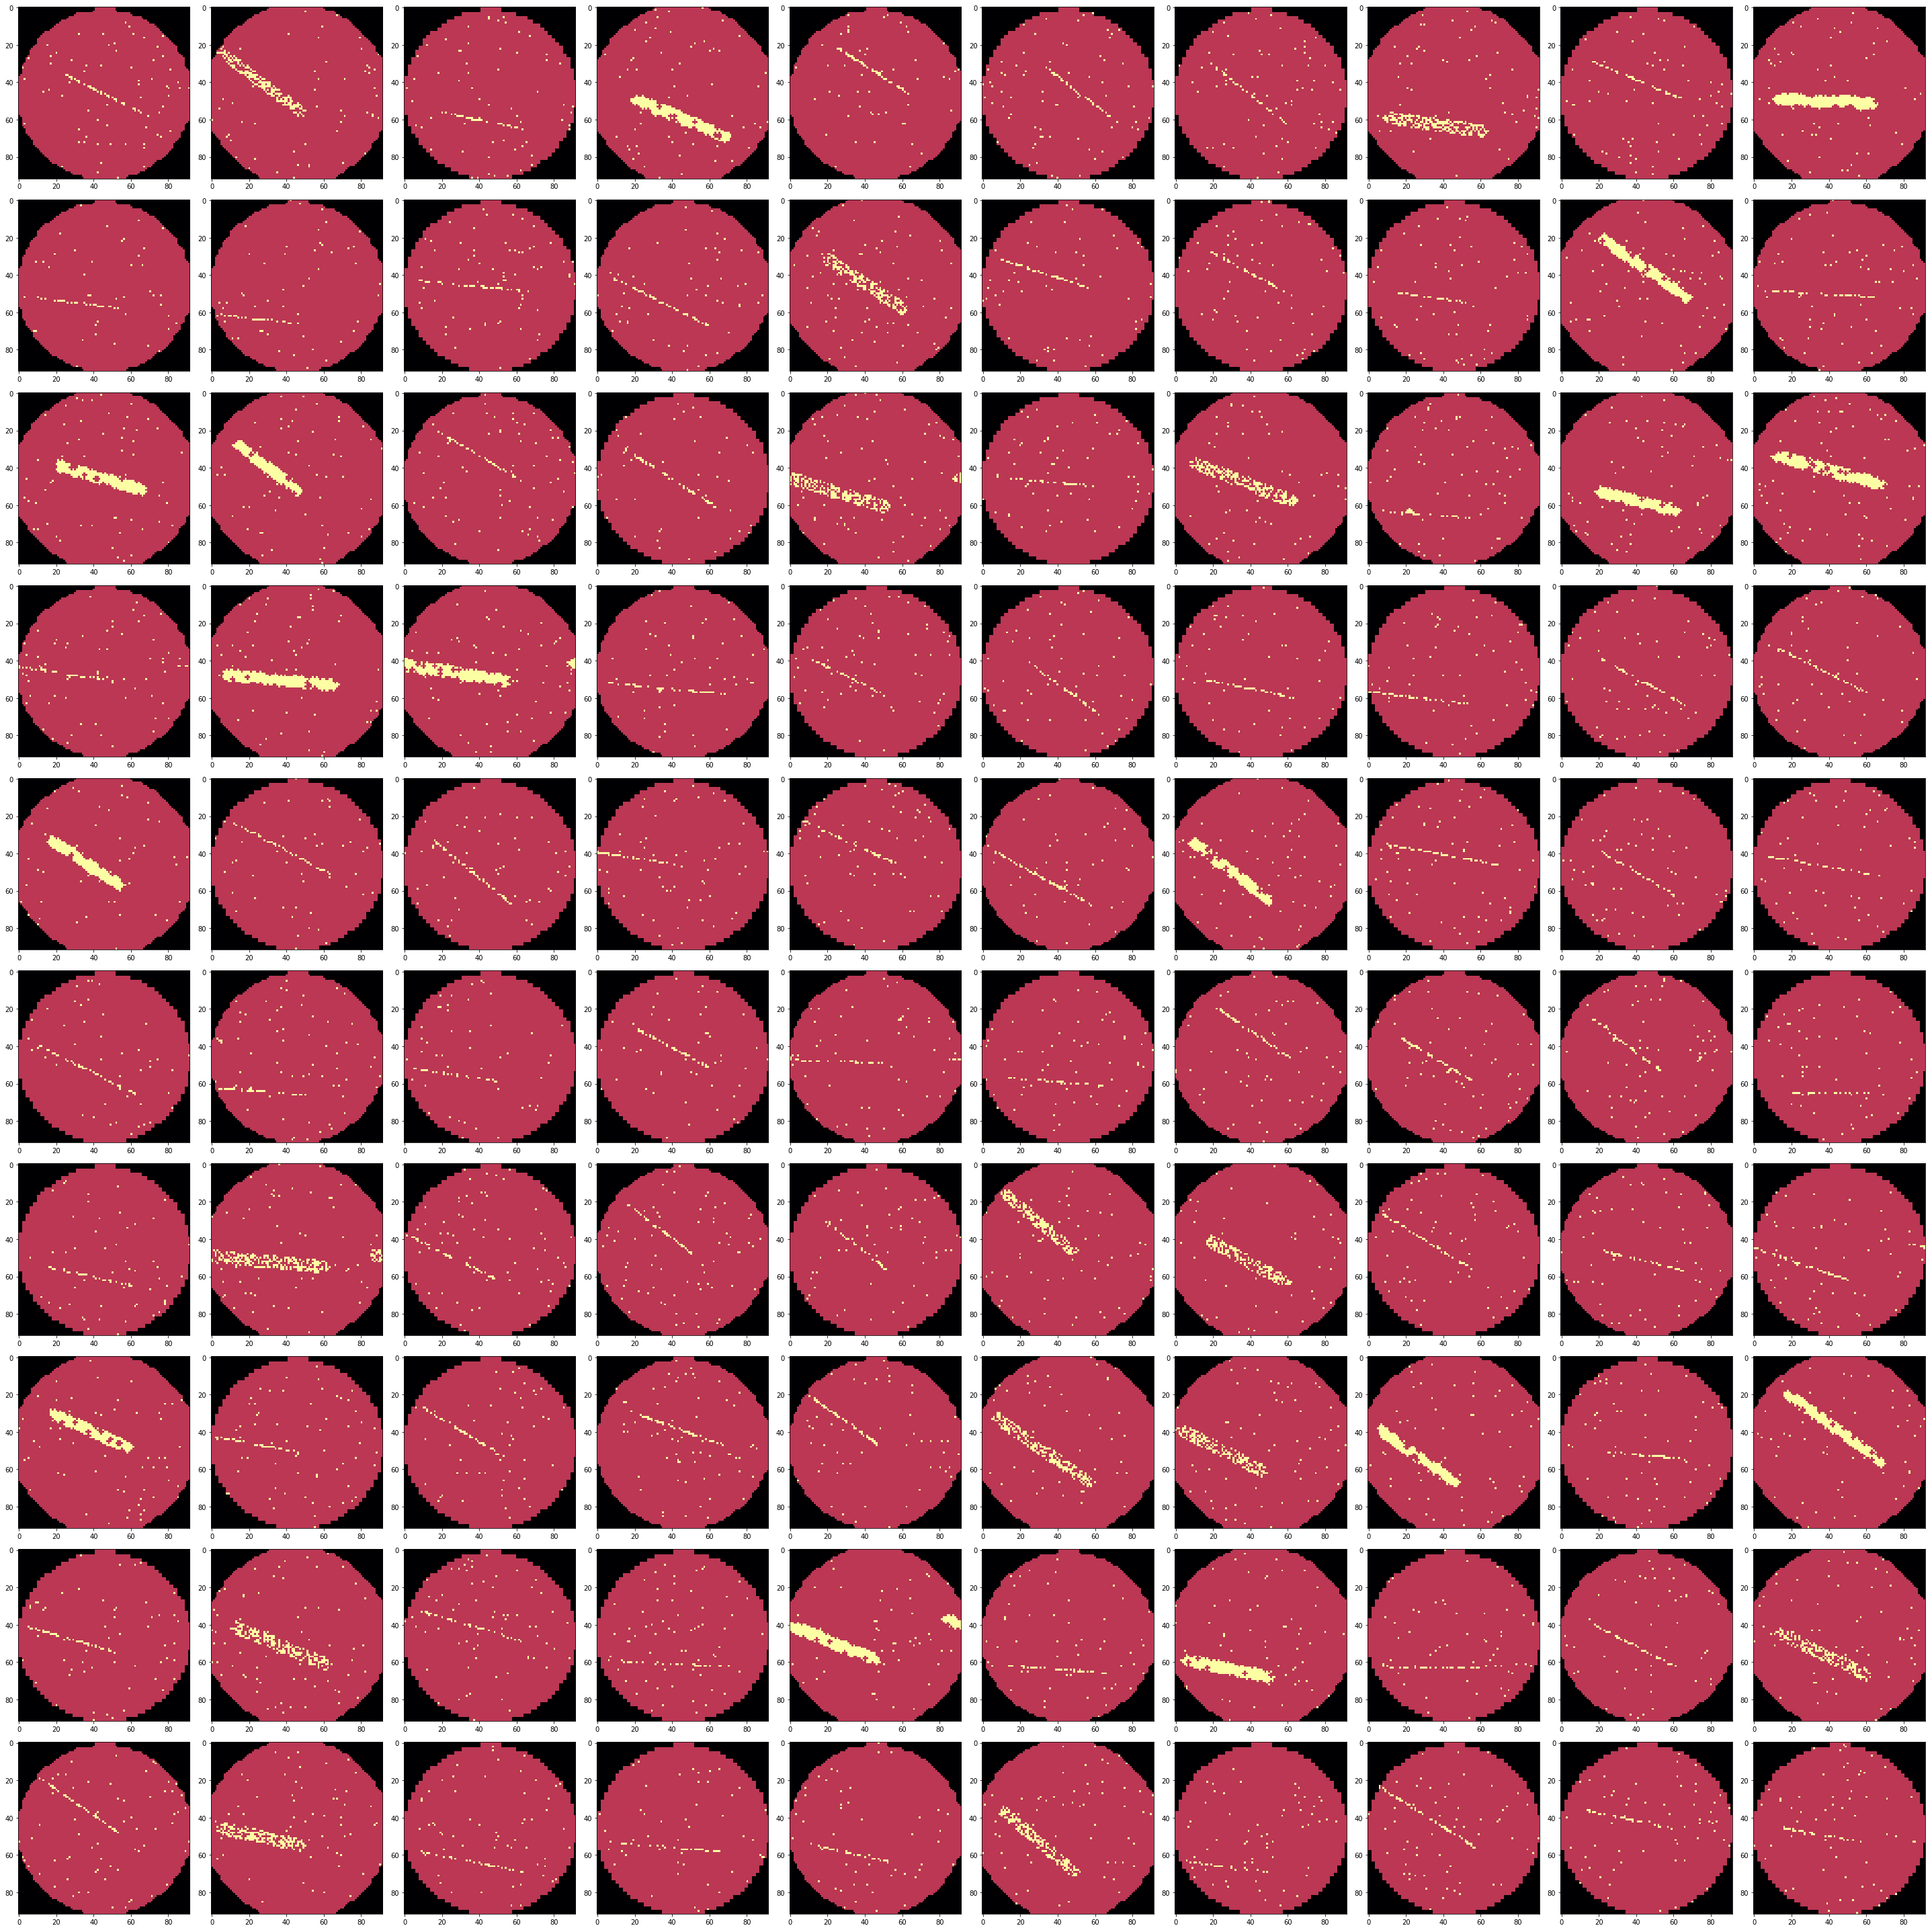

Wall time: 7.77 s


In [10]:
%%time

N_POINT = 100

L0 = np.random.randint(40, 55, size=N_POINT)

XC = np.random.randint(46, 70, size=N_POINT)
delta_xc = np.zeros(N_POINT)
XC = np.vstack((XC, delta_xc))
xc = np.array([[XC[0,i], XC[1,i]] for i in range(XC.shape[1])])

YC = np.random.randint(46, 70, size=N_POINT)
delta_yc = np.zeros(N_POINT)
YC = np.vstack((YC, delta_yc))
yc = np.array([[YC[0,i], YC[1,i]] for i in range(YC.shape[1])])

angle1 = np.random.randint(-130, -90, size=N_POINT) * np.pi/180
angle = np.vstack((angle1, angle1))
angle = np.array([[angle[0,i], angle[1,i]] for i in range(angle.shape[1])])

angle.shape, xc.shape, yc.shape, L0.shape
sawtooth_line(xc, yc, L0, angle, line_count=2)

# Генератор колец 

In [11]:
def plot_rings(XC, YC, R_, PHI, N, lam_poisson=1.2):
    size = XC.shape[0]
    fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(40, 40))
    ax = ax.ravel(order='C')
    for n in range(size):
        ## параметры кольца
        phi = np.linspace(PHI[n][0], PHI[n][1], N[n])
        r = np.linspace(R_[n][0], R_[n][1], N[n])
        xc = XC[n]
        yc = YC[n]

        ## синтез сетки
        R, Fi = np.meshgrid(r, phi)
        X = R*(np.cos(Fi)) + xc
        Y = R*(np.sin(Fi)) + yc
        X_ = np.around(X)
        Y_ = np.around(Y)

        ## индексы для полигона
        points = []
        for i in range(X_.shape[0]):
            for j in range(X_.shape[1]):
                x = X_[i,j]
                y = Y_[i,j]
                points.append((x,y))

        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2
        
        
        for idx in points:
            i, j = idx
            i = int(round(i))
            j = int(round(j))
            try:
                if test[i,j] == 1:
                    test[i,j] = COLOR_SCALE
            except IndexError:
                break
                
        
        is_dilate = random.randint(-1,1)
        if is_dilate == 1:
            ## сверткой расширим
            kernel = np.ones((3,3), np.uint8)
            kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
            test = cv2.dilate(test,kernel,iterations = 3)
            test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, kernel)


        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)


        ax[n].imshow(noise_img, cmap='inferno')
        
    plt.tight_layout()
    plt.show()

## Rings

In [12]:
%%time

N_POINTS = 100

PHI1 = np.random.uniform(0, 120, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(250, 360, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(18, 20, size=N_POINTS)
r2 = np.random.randint(20, 25, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(30, 50 , size=N_POINTS)
YC = np.random.randint(30, 50, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 974 µs


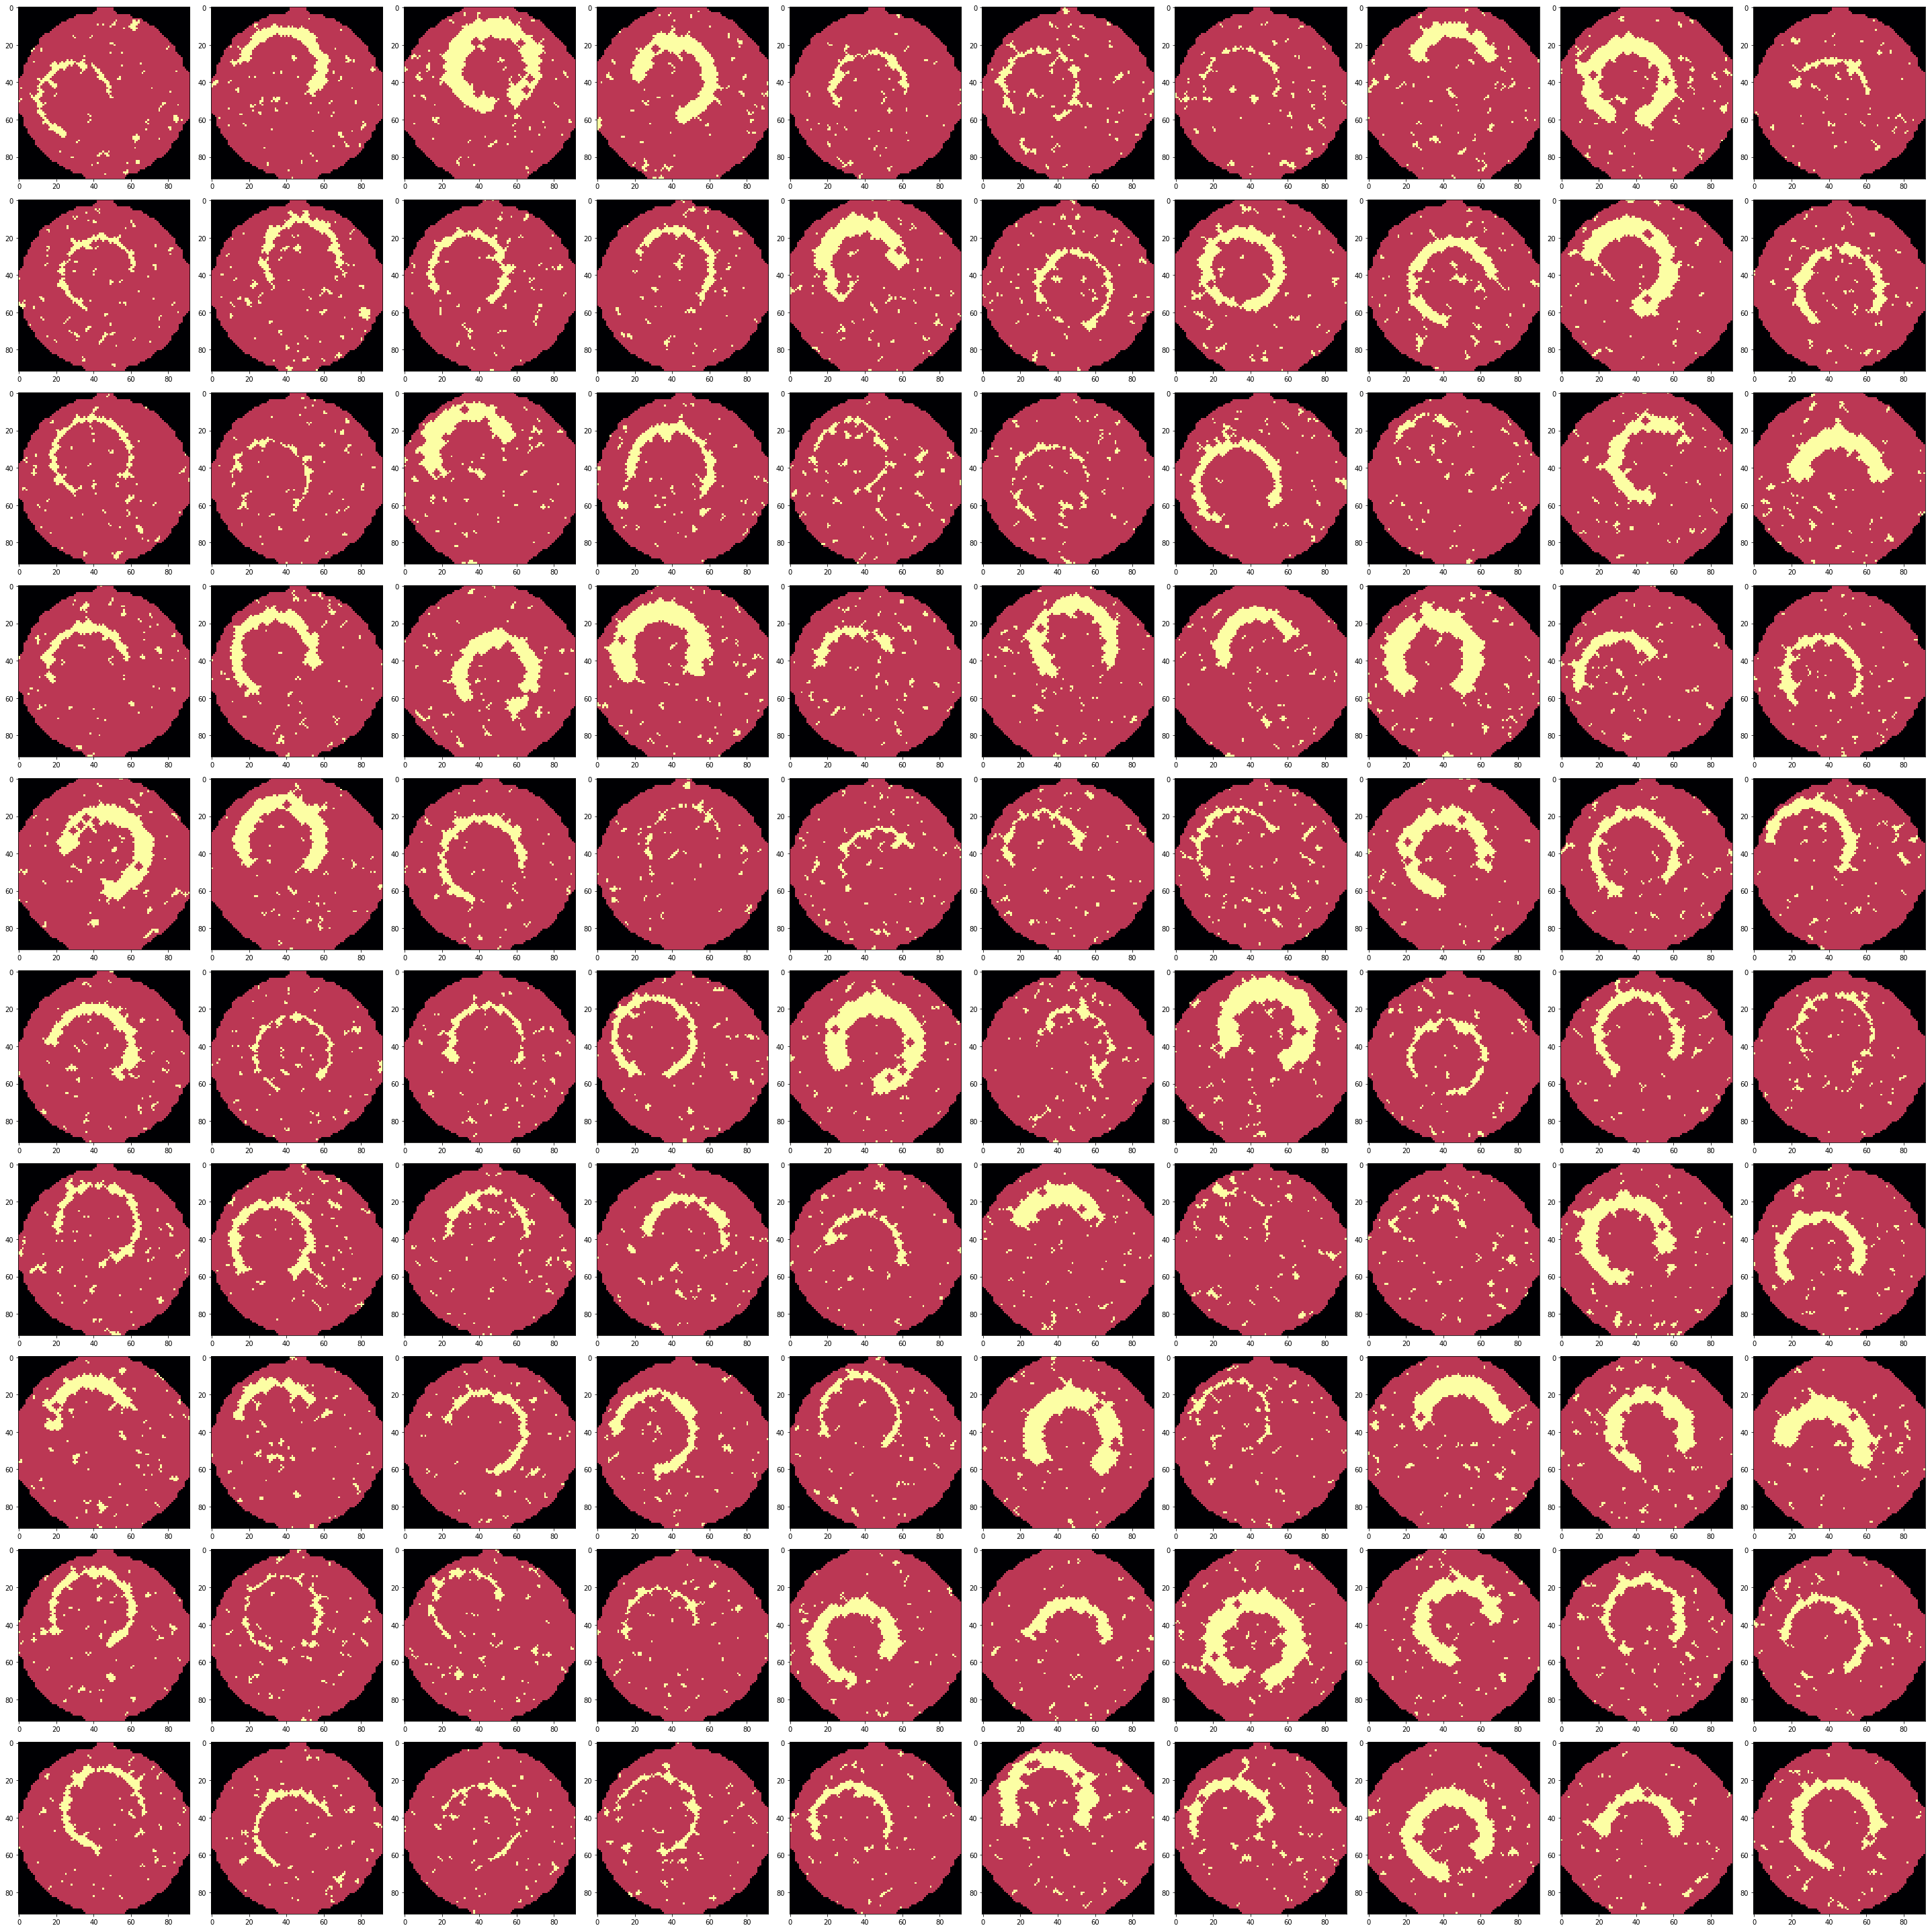

Wall time: 26.3 s


In [13]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Loc 

In [14]:
%%time

N_POINTS = 100

PHI1 = np.random.uniform(20, 34, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(40, 70, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(25, 30, size=N_POINTS)
r2 = np.random.randint(30, 33, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(20, 70 , size=N_POINTS)
YC = np.random.randint(20, 70, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 0 ns


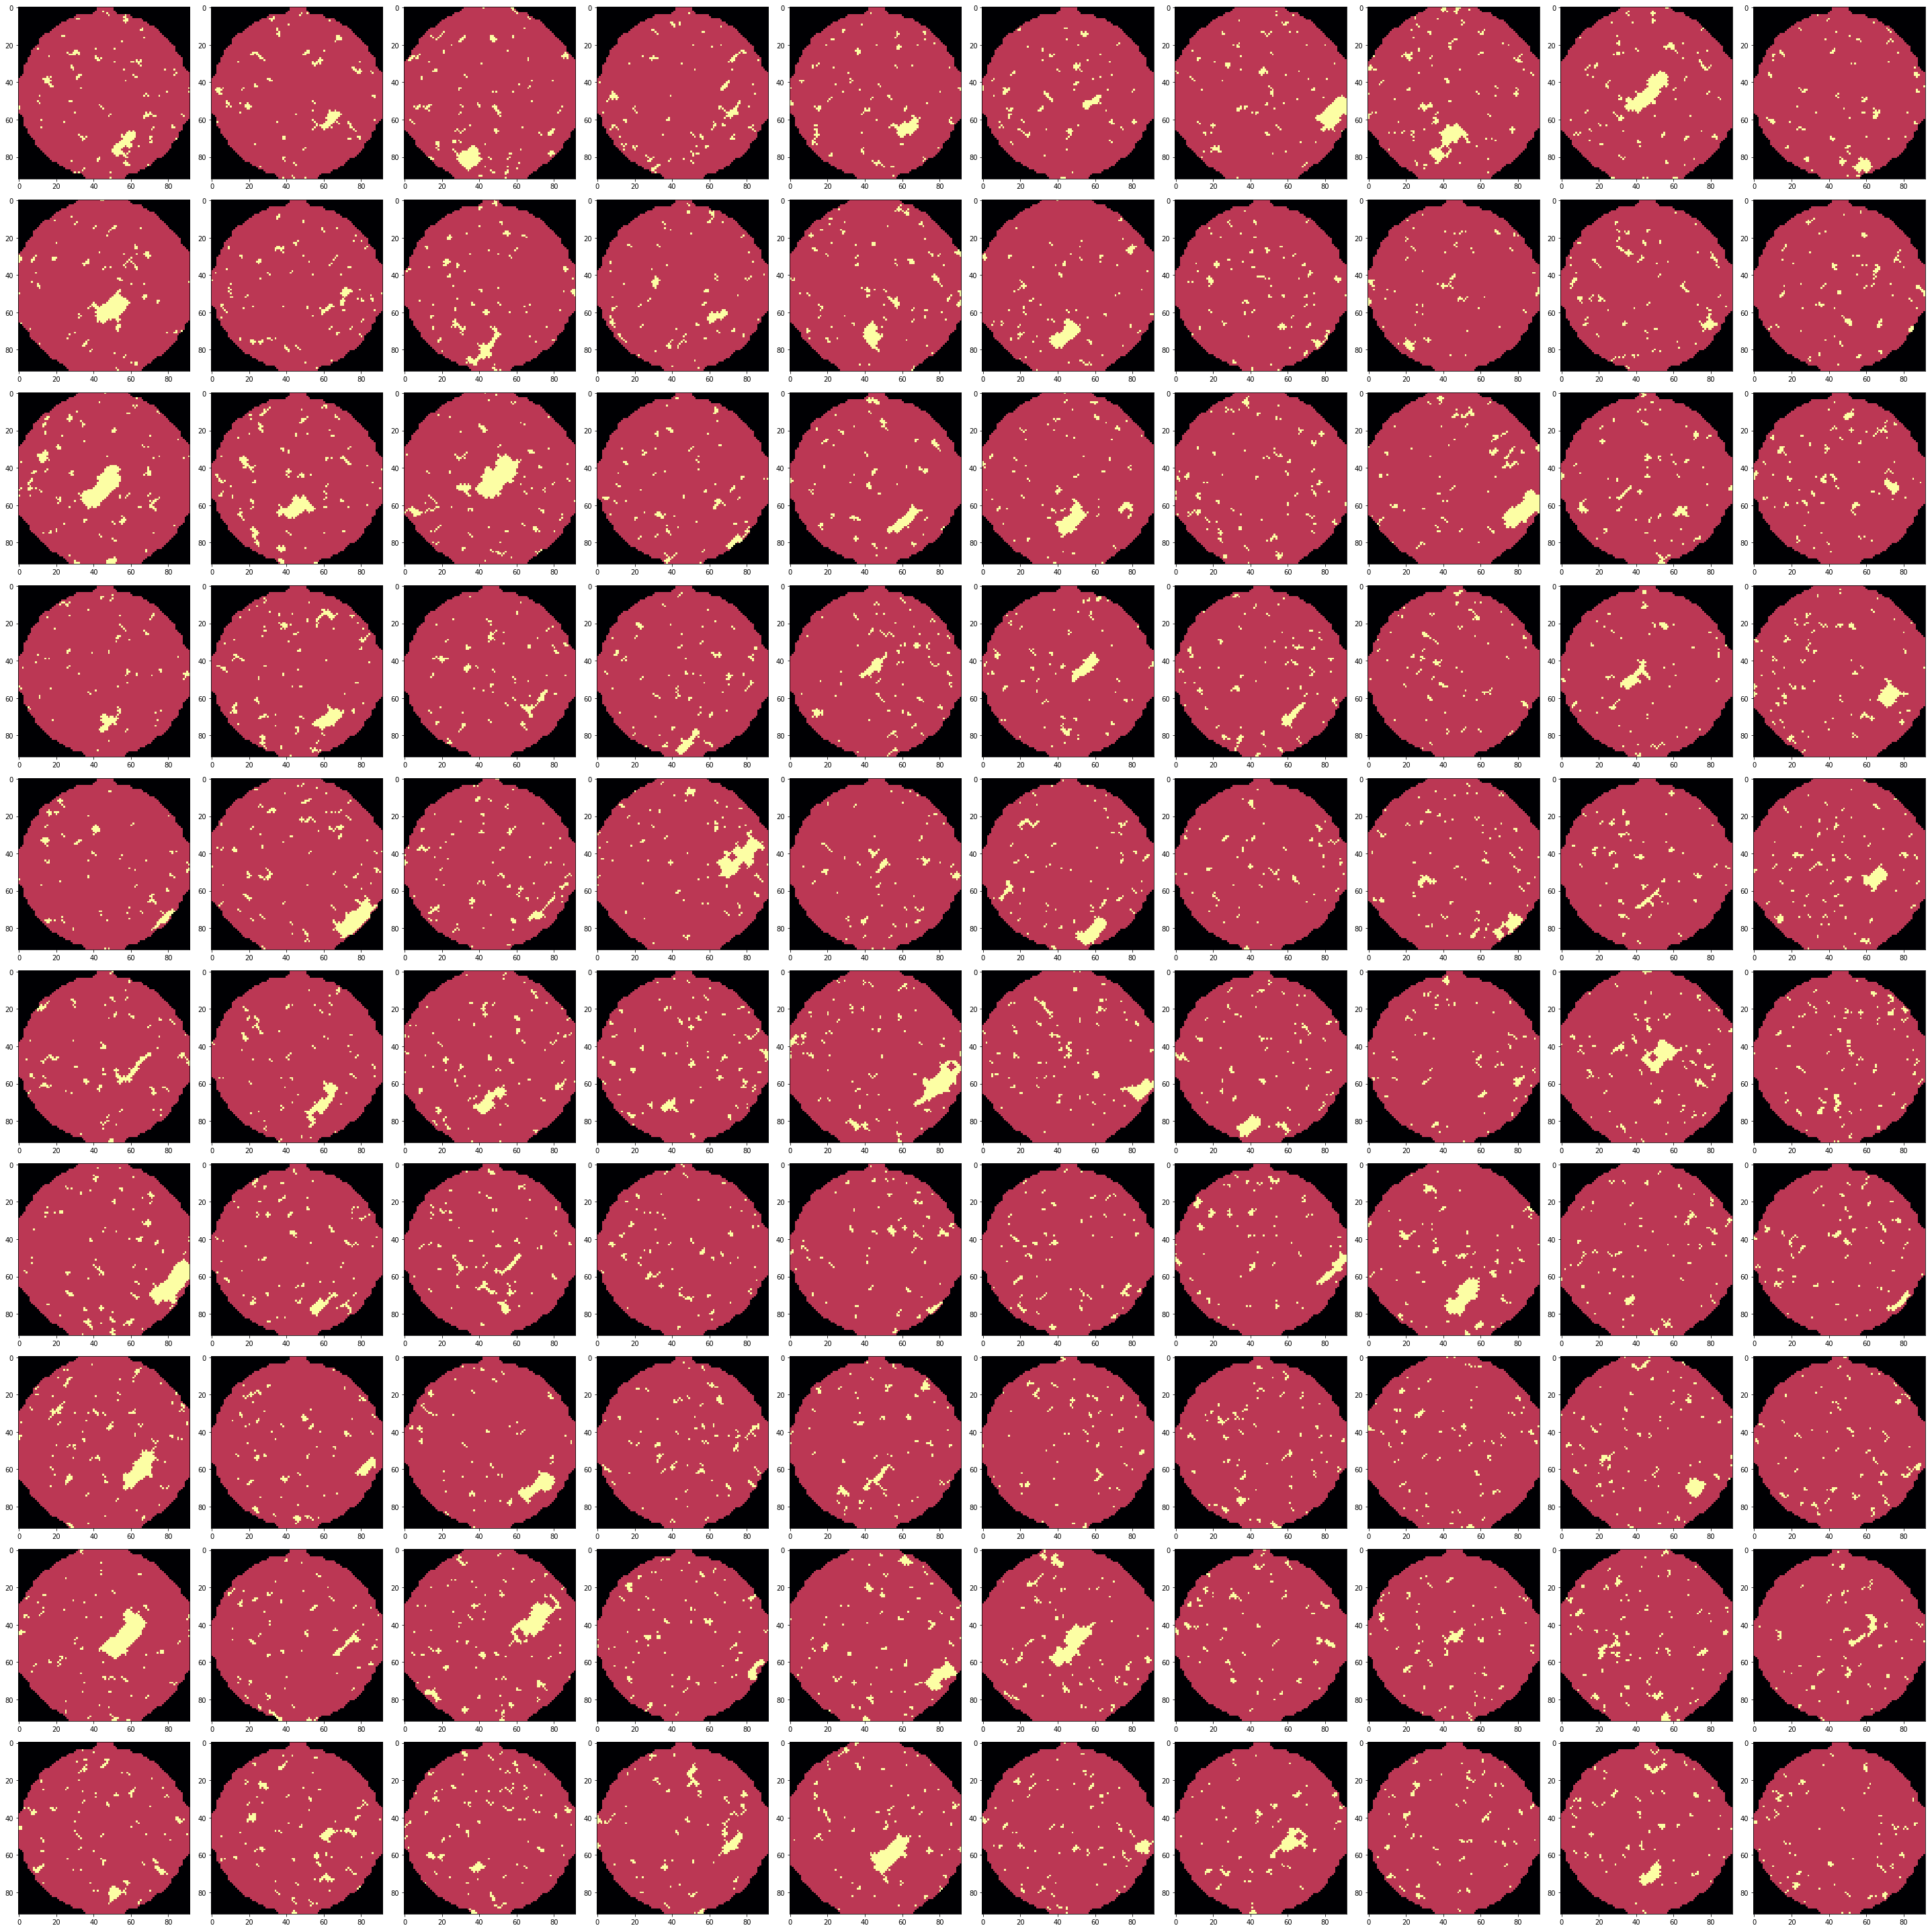

Wall time: 24.9 s


In [15]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Center 

In [16]:
%%time

N_POINTS = 100

PHI1 = np.random.uniform(20, 30, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(45, 70, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(0, 1, size=N_POINTS)
r2 = np.random.randint(7, 15, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(42, 48, size=N_POINTS)
YC = np.random.randint(42, 48, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 0 ns


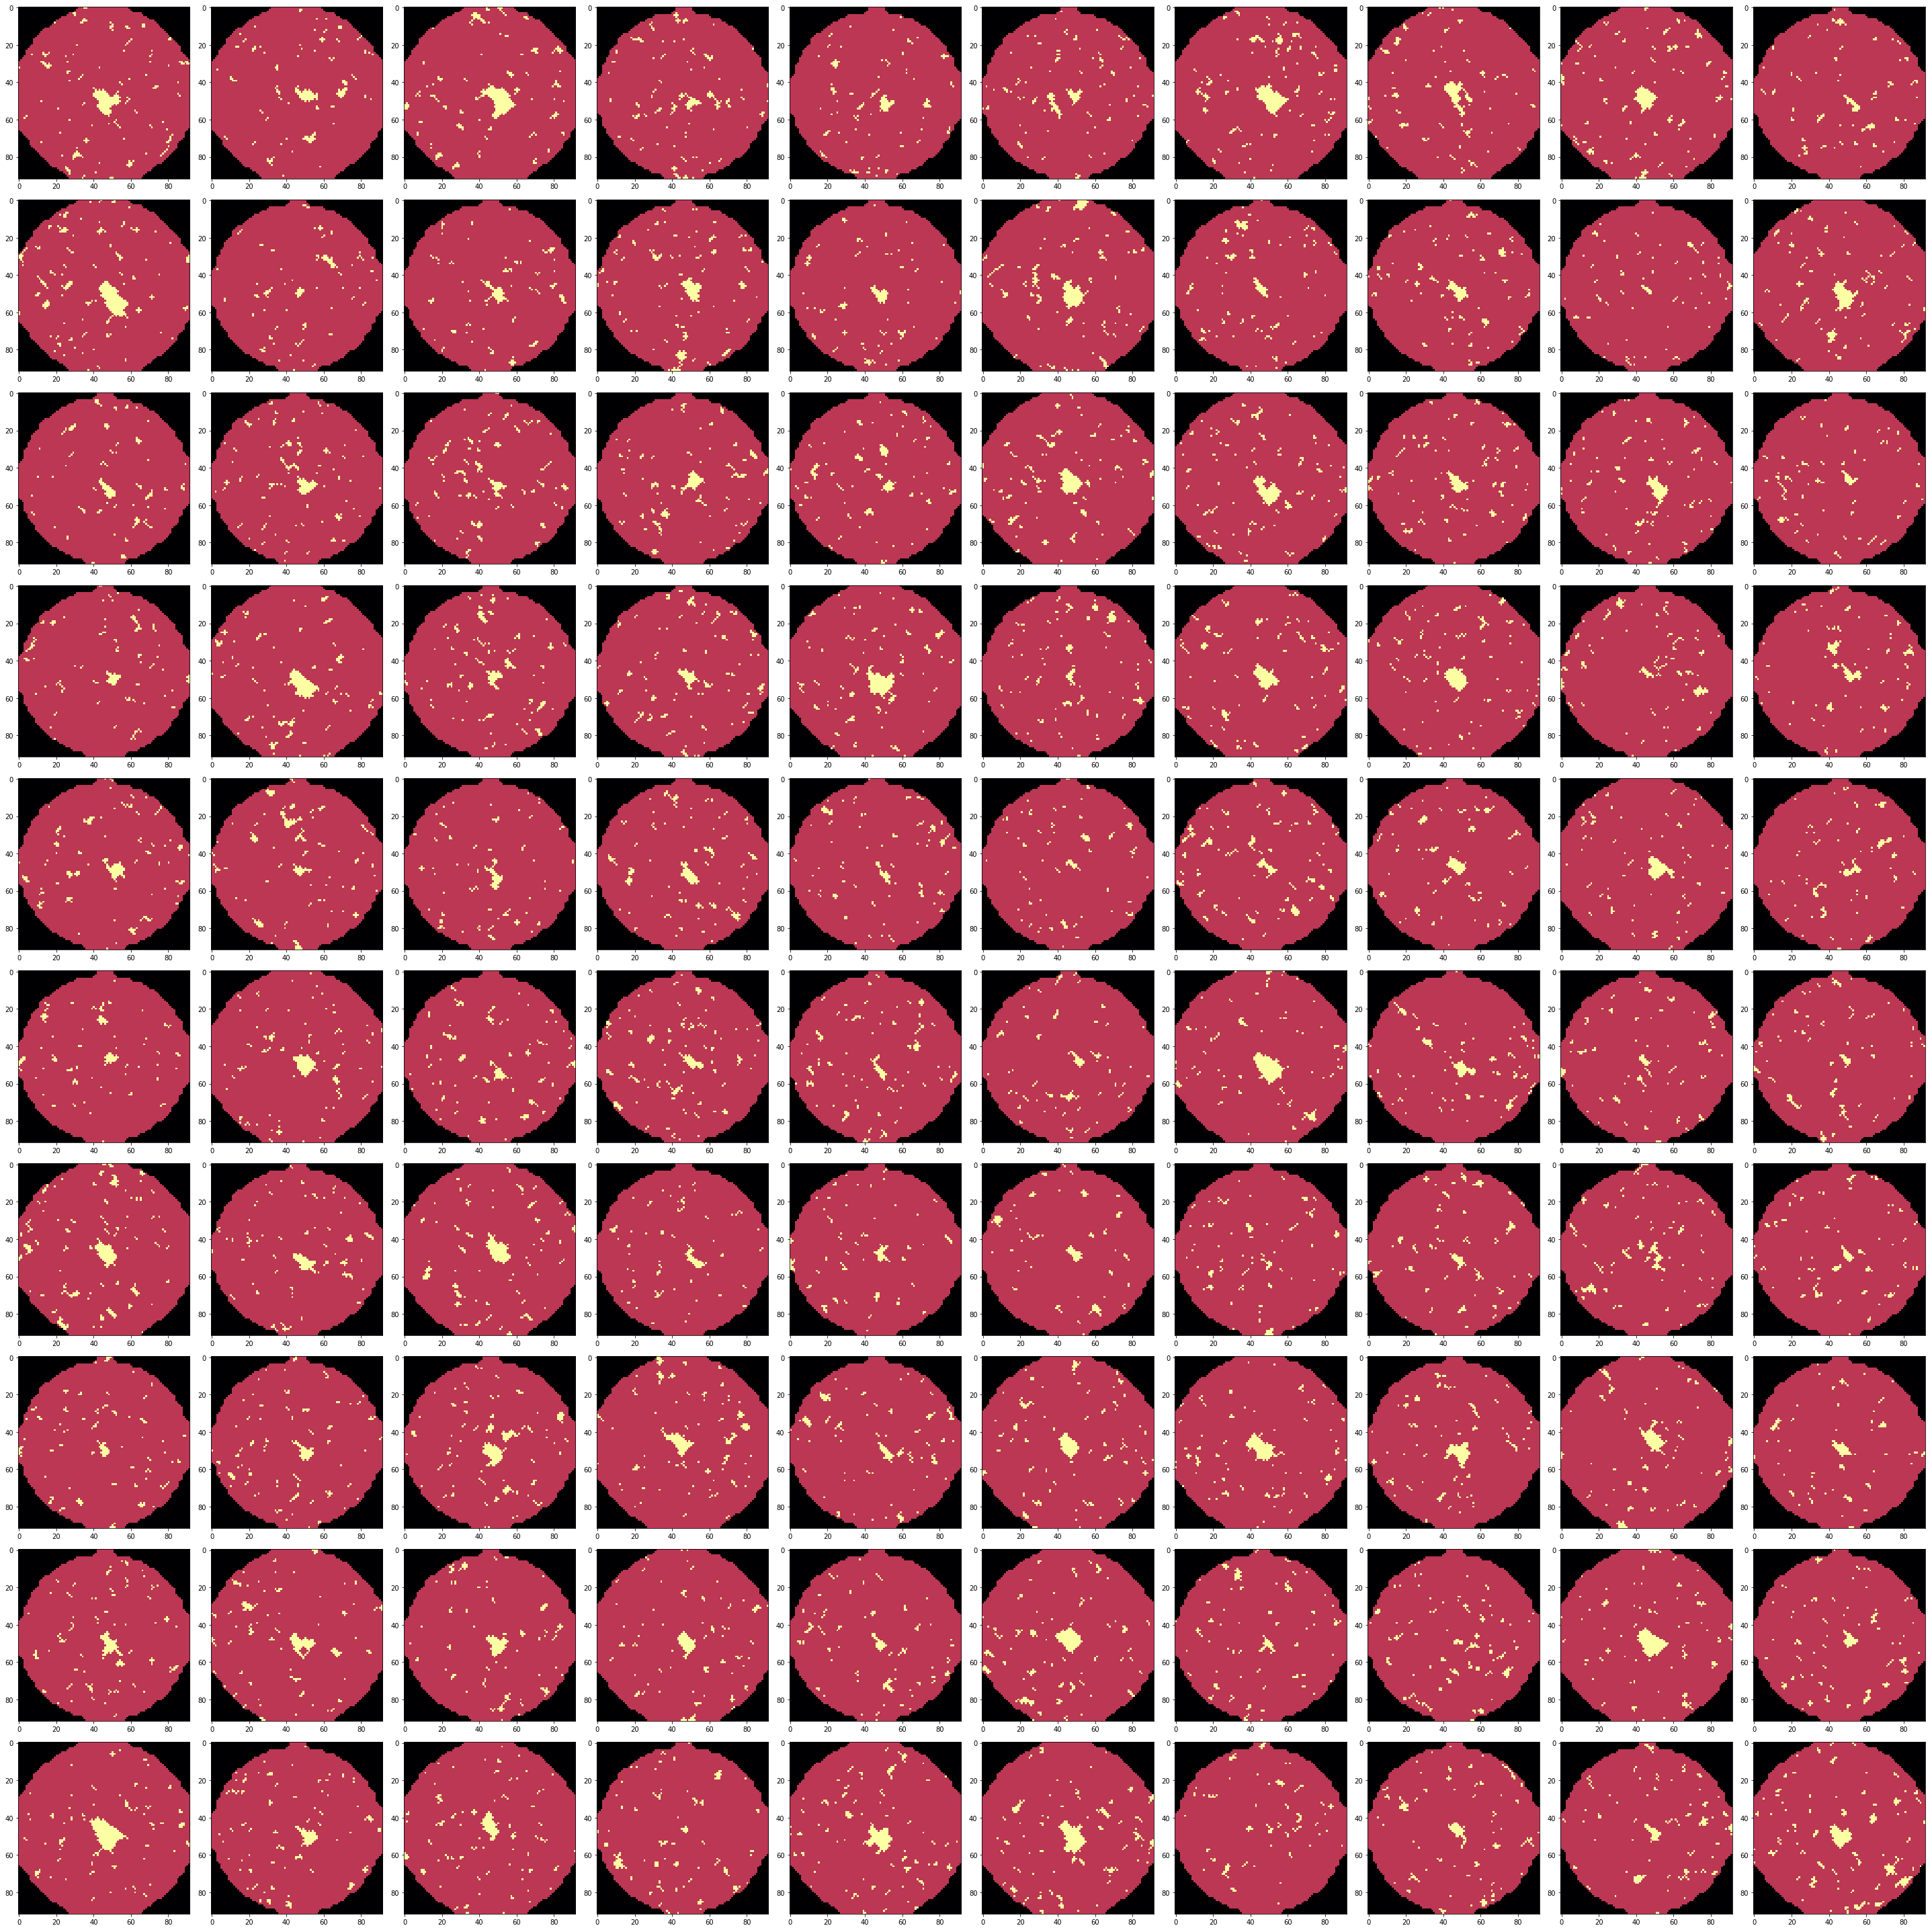

Wall time: 26.4 s


In [17]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Random sky

In [18]:
%%time

N_POINTS = 100

PHI1 = np.random.uniform(70, 80, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(84, 112, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(0, 2, size=N_POINTS)
r2 = np.random.randint(10, 17, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(25, 65, size=N_POINTS)
YC = np.random.randint(25, 65, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 0 ns


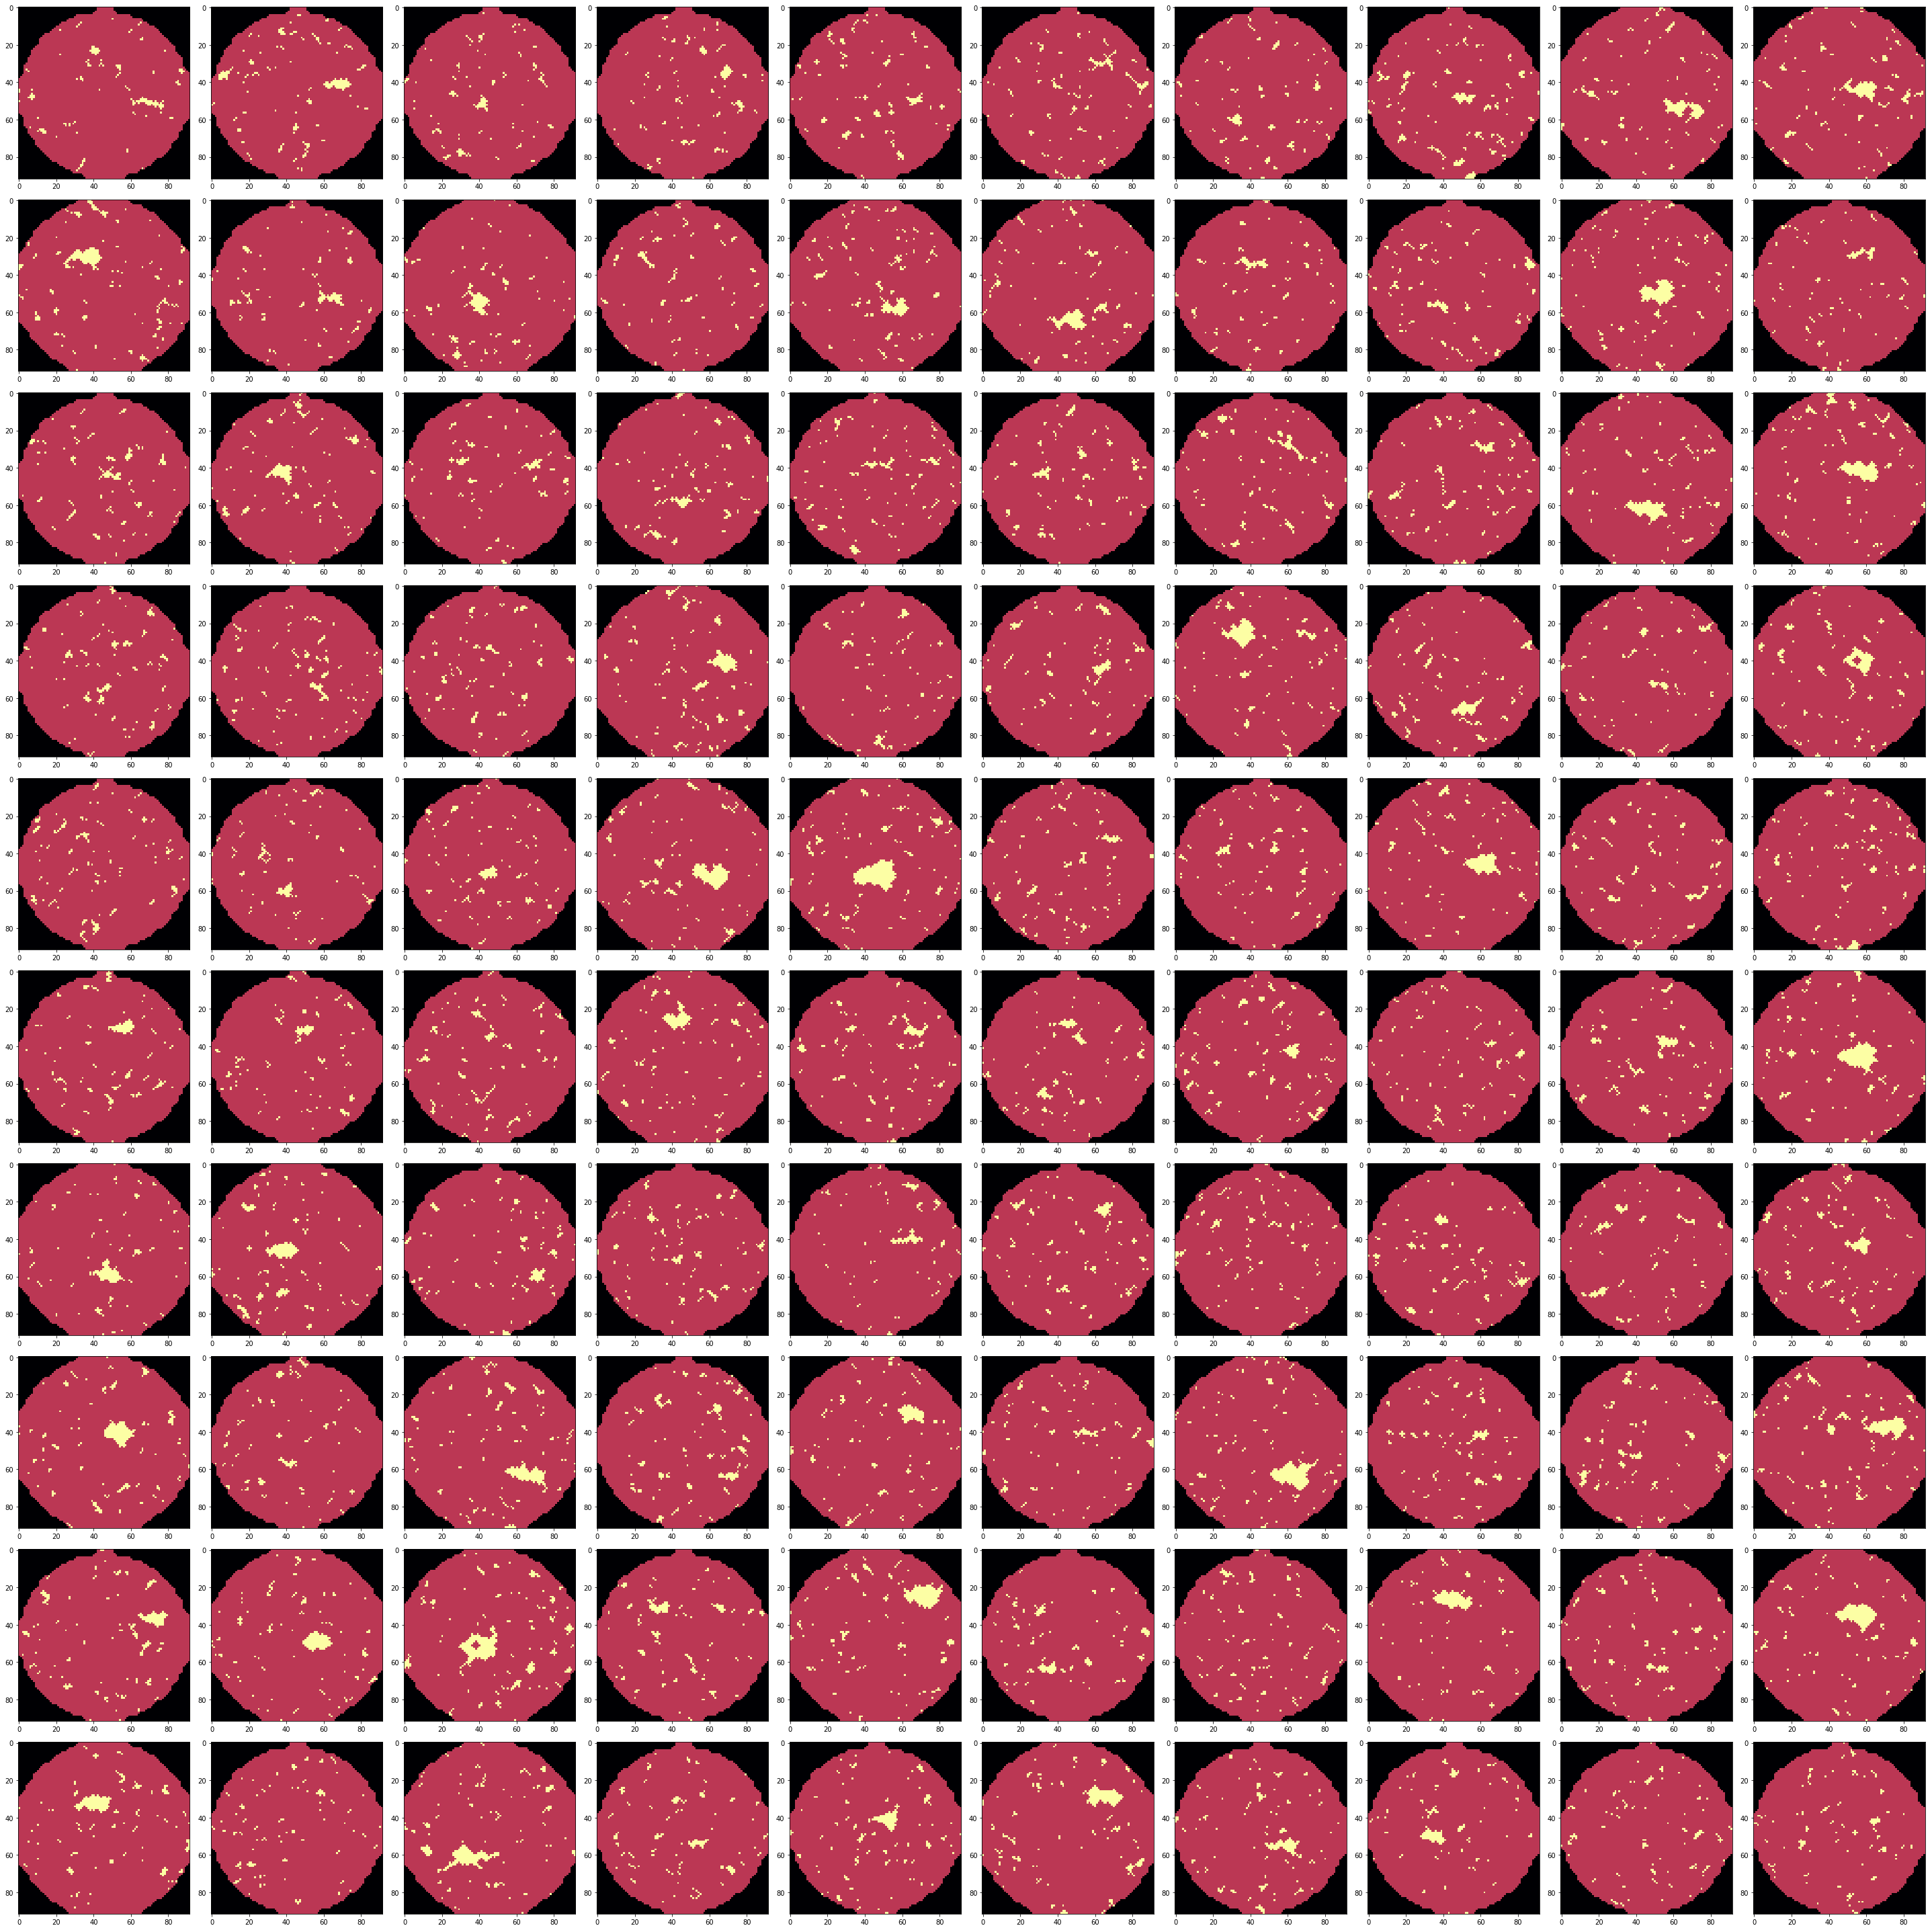

Wall time: 26.4 s


In [19]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Edge-Ring 

In [20]:
%%time

N_POINTS = 100

PHI1 = np.random.uniform(0, 90, size=N_POINTS) * np.pi/180
PHI2 = np.random.uniform(210, 360, size=N_POINTS) * np.pi/180
PHI = np.vstack((PHI1, PHI2))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(42, 43, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 0 ns


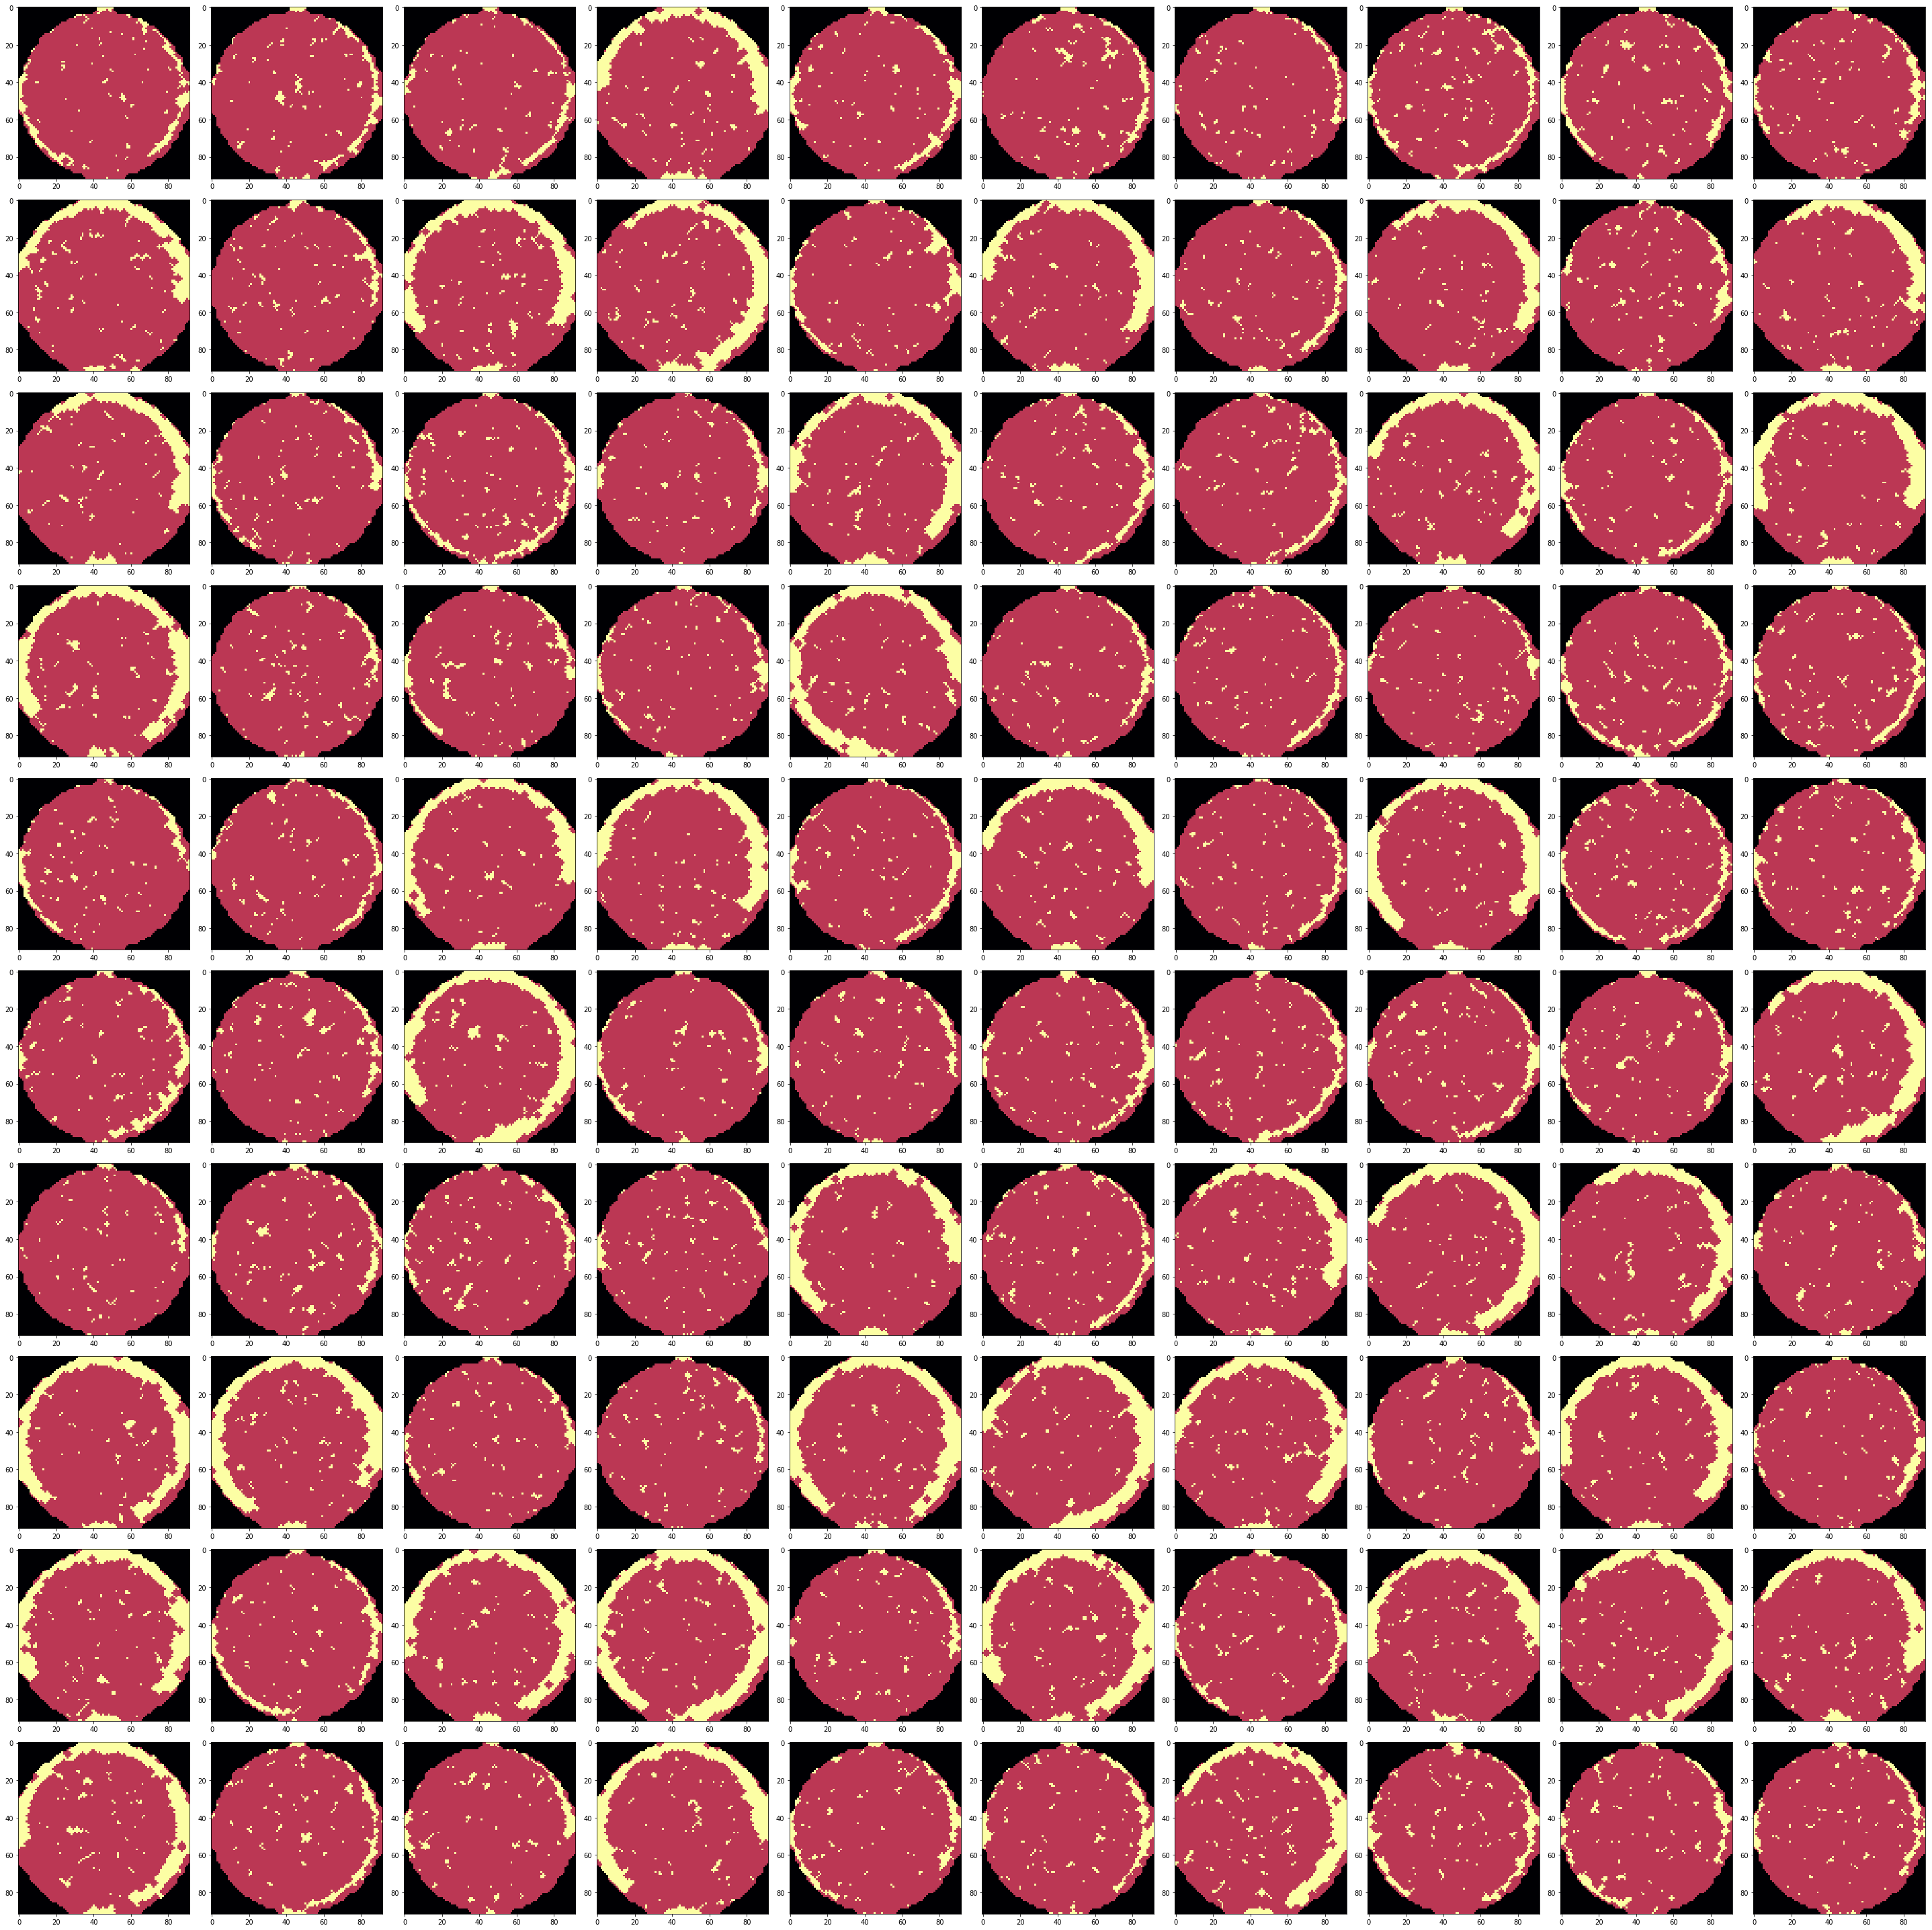

Wall time: 27.1 s


In [21]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Edge-Loc 

In [22]:
%%time

N_POINTS = 100

## 1 quadrant
PHI1_1 = np.random.uniform(0, 30, size=N_POINTS) * np.pi/180
PHI2_1 = np.random.uniform(60, 120, size=N_POINTS) * np.pi/180

## 2 quandrant
PHI1_2 = np.random.uniform(90, 120, size=N_POINTS) * np.pi/180
PHI2_2 = np.random.uniform(150, 210, size=N_POINTS) * np.pi/180

## 3 quandrant
PHI1_3 = np.random.uniform(170, 180, size=N_POINTS) * np.pi/180
PHI2_3 = np.random.uniform(240, 300, size=N_POINTS) * np.pi/180

## 4 quandrant
PHI1_4 = np.random.uniform(250, 270, size=N_POINTS) * np.pi/180
PHI2_4 = np.random.uniform(280, 390, size=N_POINTS) * np.pi/180

PHI = np.vstack((PHI1_4, PHI2_4))
PHI = np.array([[PHI[0,i], PHI[1,i]] for i in range(PHI.shape[1])])

r1 = np.random.randint(37, 42, size=N_POINTS)
r2 = np.random.randint(45, 46, size=N_POINTS)
r = np.vstack((r1, r2))
r = np.array([[r[0,i], r[1,i]] for i in range(r.shape[1])])

XC = np.random.randint(44, 45 , size=N_POINTS)
YC = np.random.randint(44, 45, size=N_POINTS)

## интесивность
N = np.random.randint(200, 210, size=N_POINTS)

Wall time: 1.01 ms


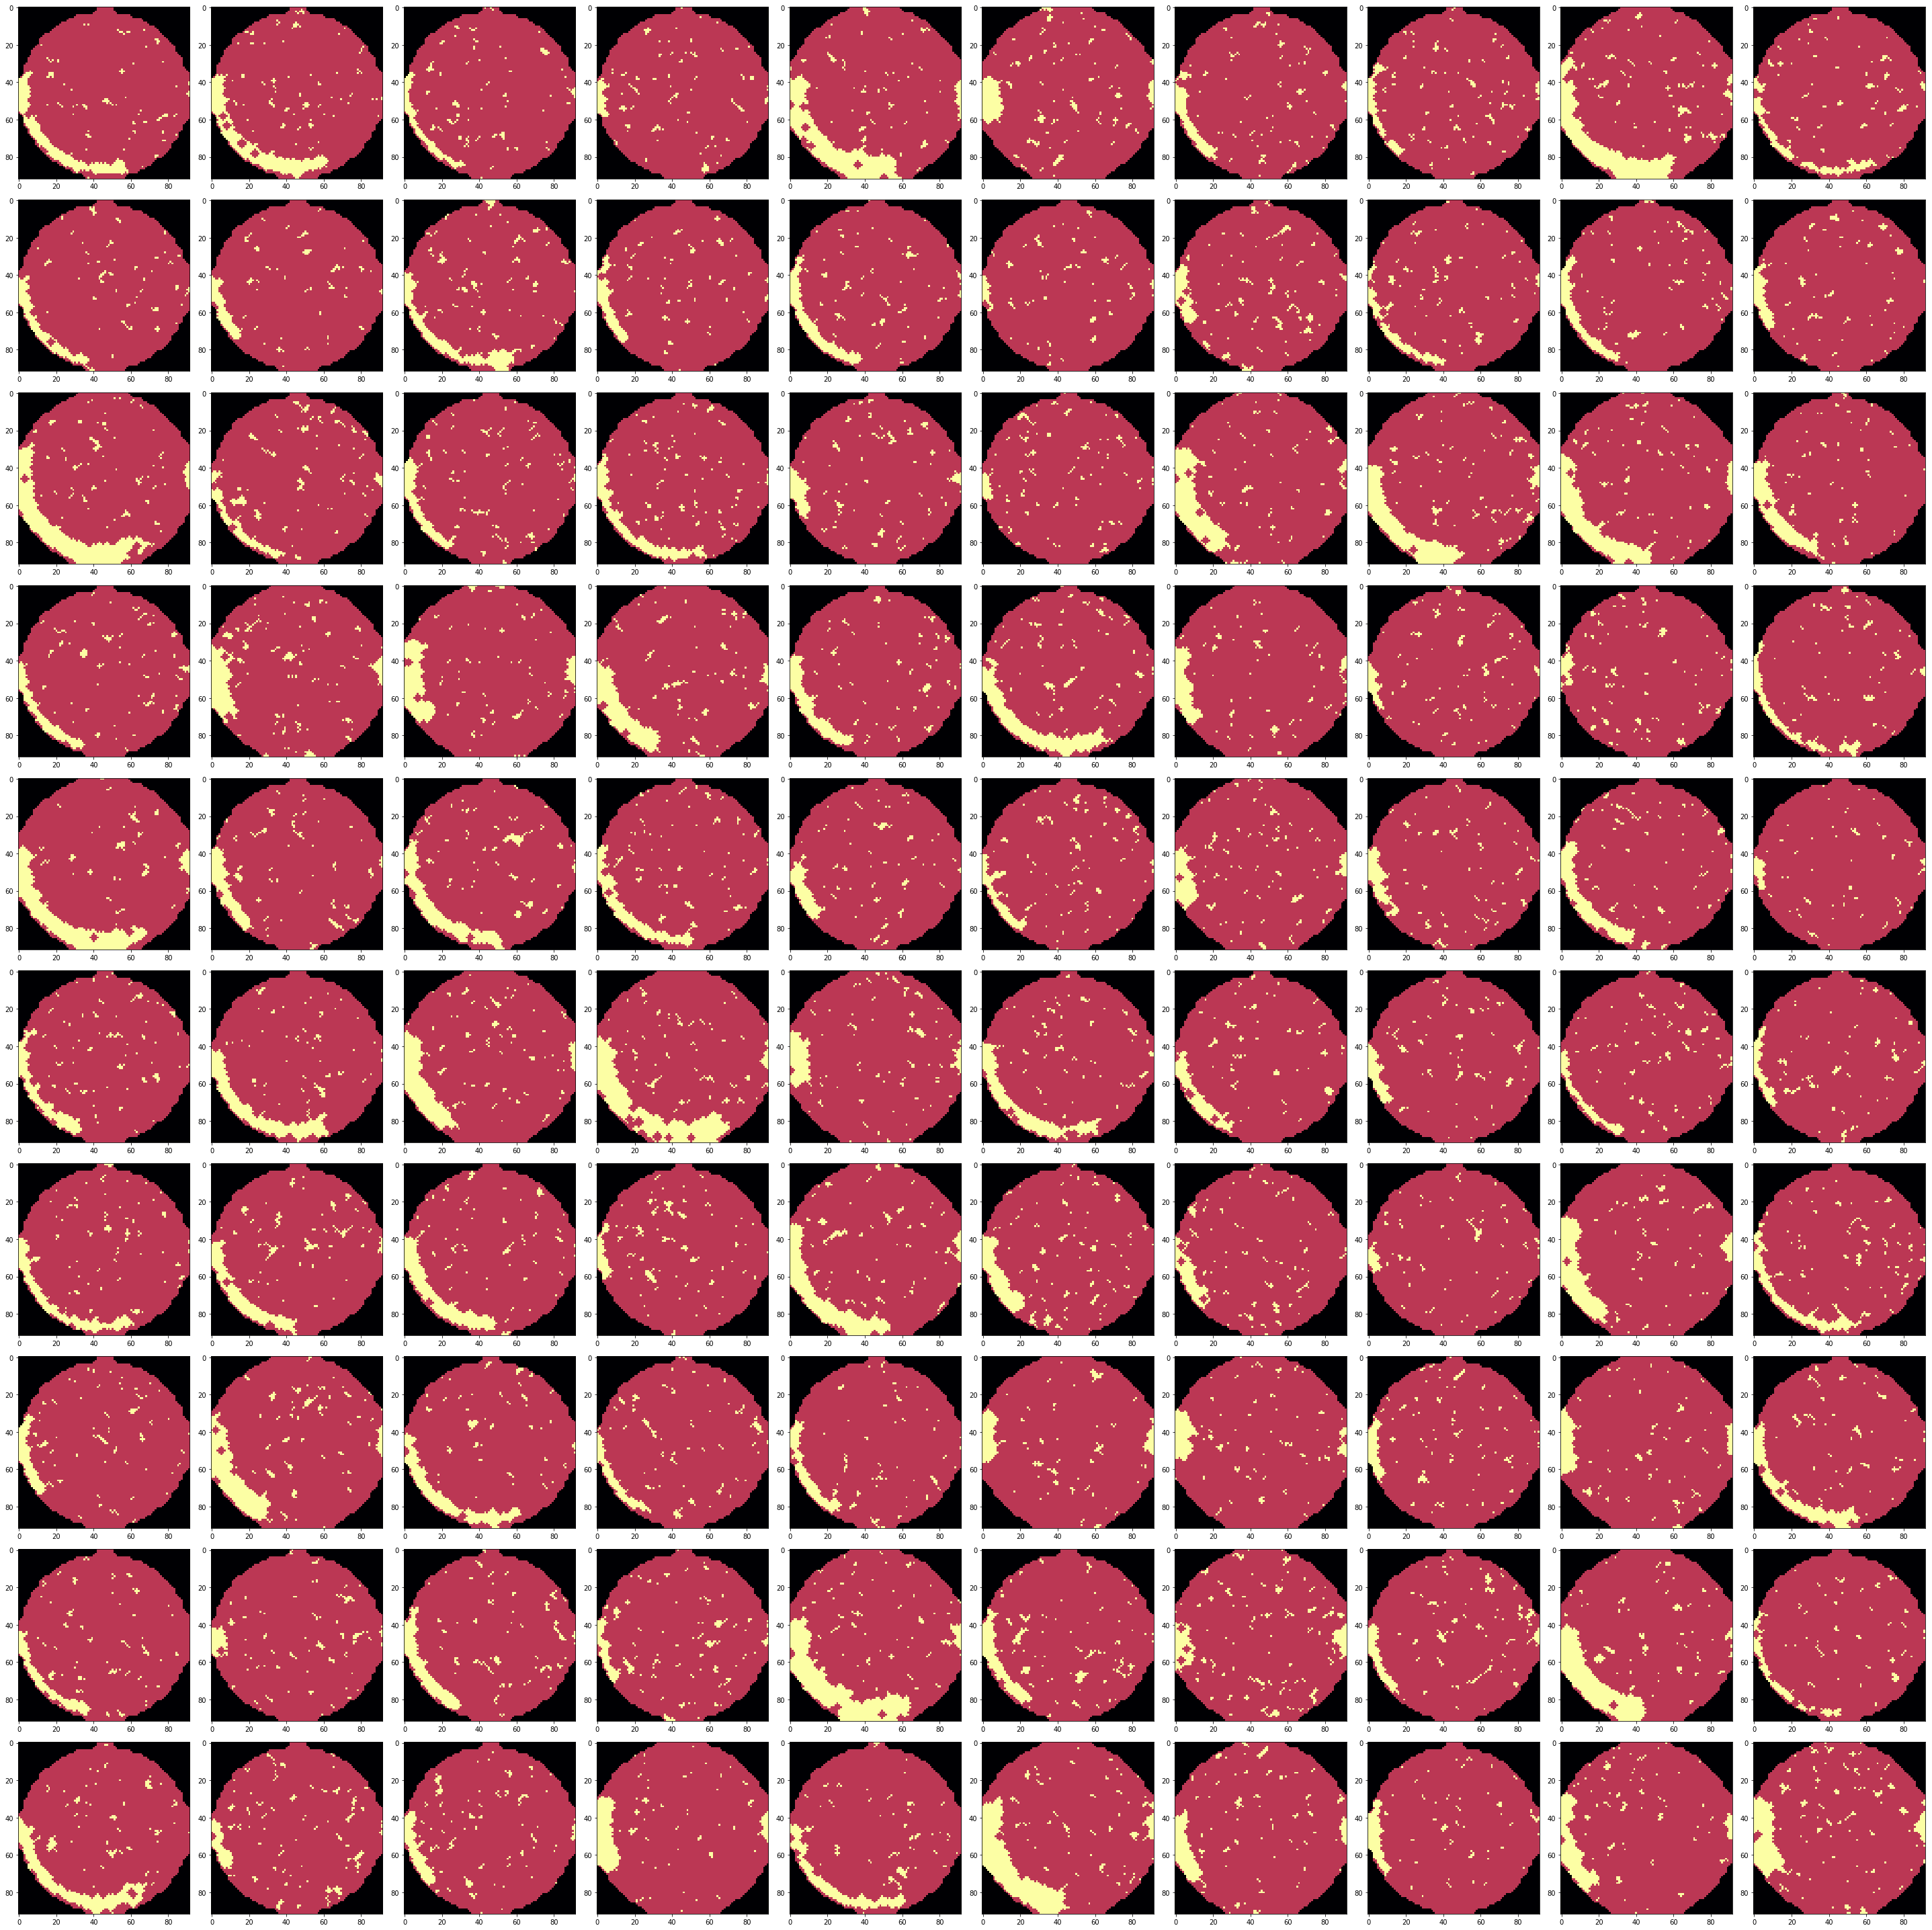

Wall time: 26.3 s


In [23]:
%%time
plot_rings(XC, YC, r, PHI, N)

## Near-full

In [24]:
def plot_near_full(N, lam_poisson=1.2):
    fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(40, 40))
    ax = ax.ravel(order='C')
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r==1] = 2
        r[r>2] = 1
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)


        ax[n].imshow(noise_img, cmap='inferno')
        
    plt.tight_layout()
    plt.show()

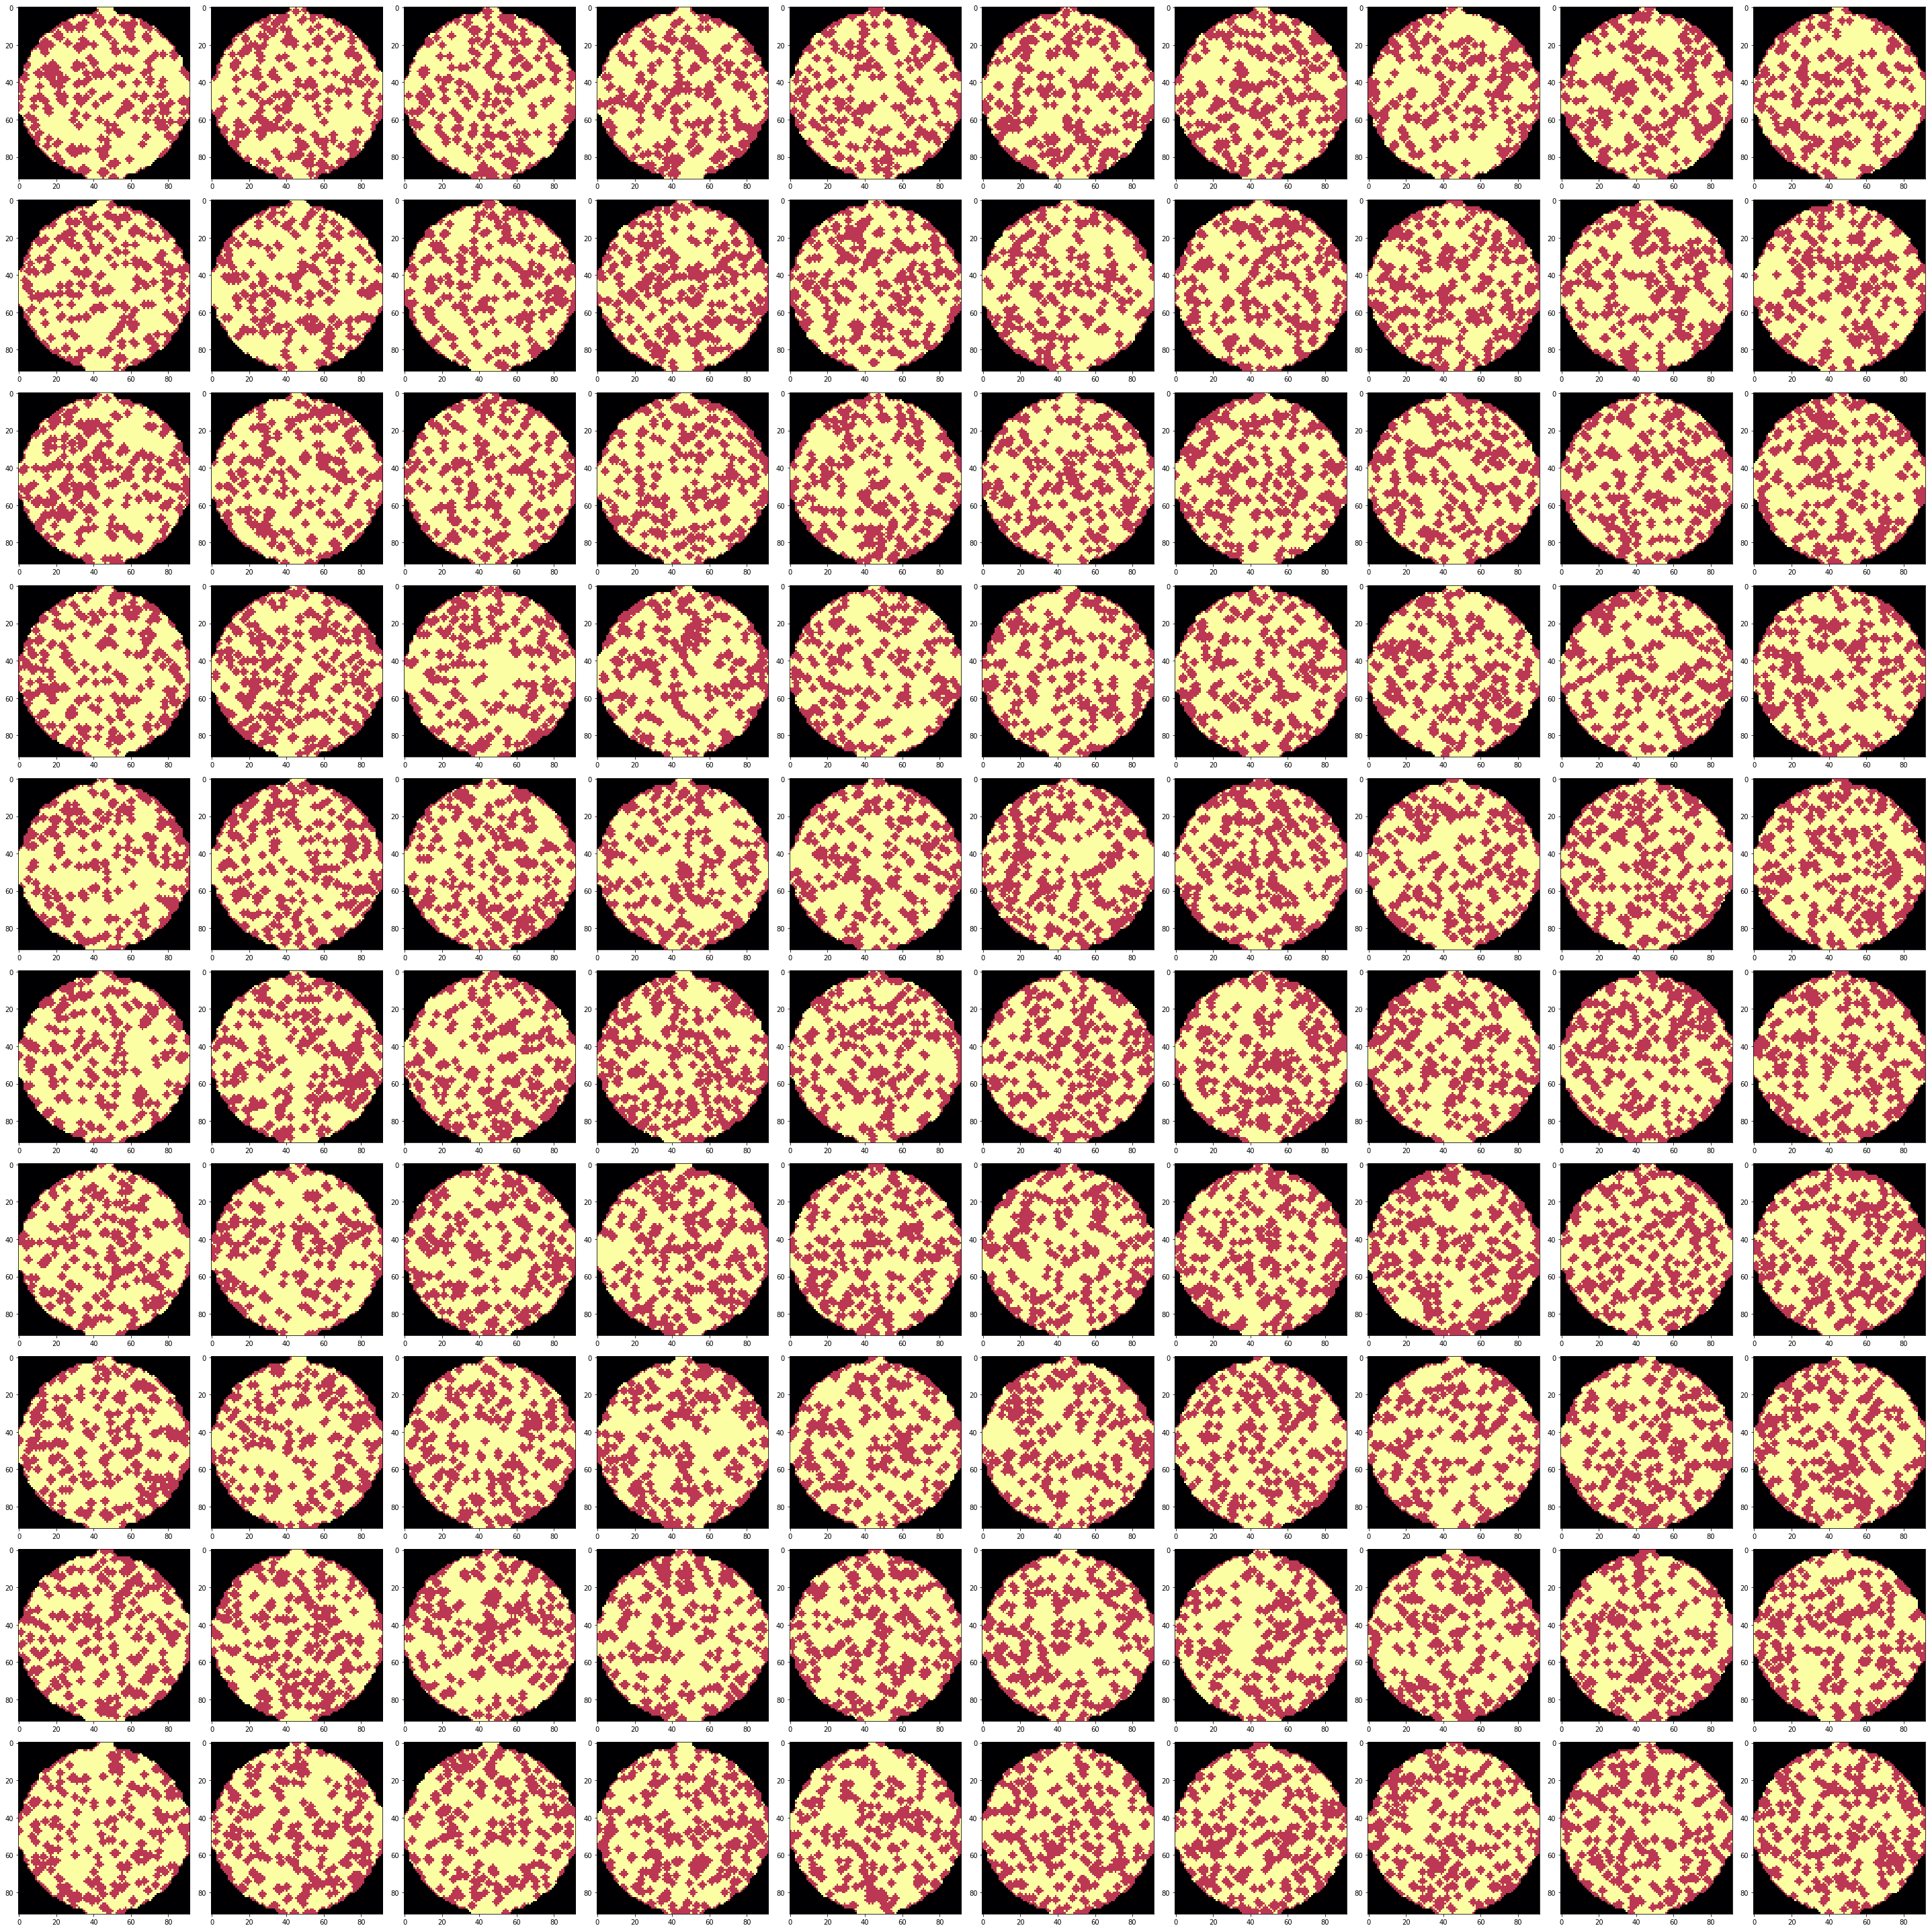

In [25]:
plot_near_full(100, lam_poisson=1)

## Random

In [26]:
def plot_random(N, lam_poisson=1.2):
    fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(40, 40))
    ax = ax.ravel(order='C')
    for n in range(N):
        ## создадим тестовый полигон
        test = cv2.resize(wafer_map.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
        ## 2 - паттерн
        ## 1 - фон
        ## 0 - область, где нет ничего
        test[test == 2] = 1
        COLOR_SCALE = 2

        ## внесем шум
        noise_img = test.copy()
        mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
        mask[noise_img == 0] = False
        r = np.random.poisson(lam=lam_poisson, size=noise_img.shape)
        # нормировка на шумы
        # r = np.around(r//np.max(r))
        r[r==0] = 1
        r[r>2] = 2
        noise_img[mask] = r[mask]
        

        ## сверткой расширим
        kernel = np.ones((3,3), np.uint8)
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
        noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE, kernel)
        noise_img = cv2.erode(noise_img,kernel,iterations = 1)


        ax[n].imshow(noise_img, cmap='inferno')

    plt.tight_layout()
    plt.show()

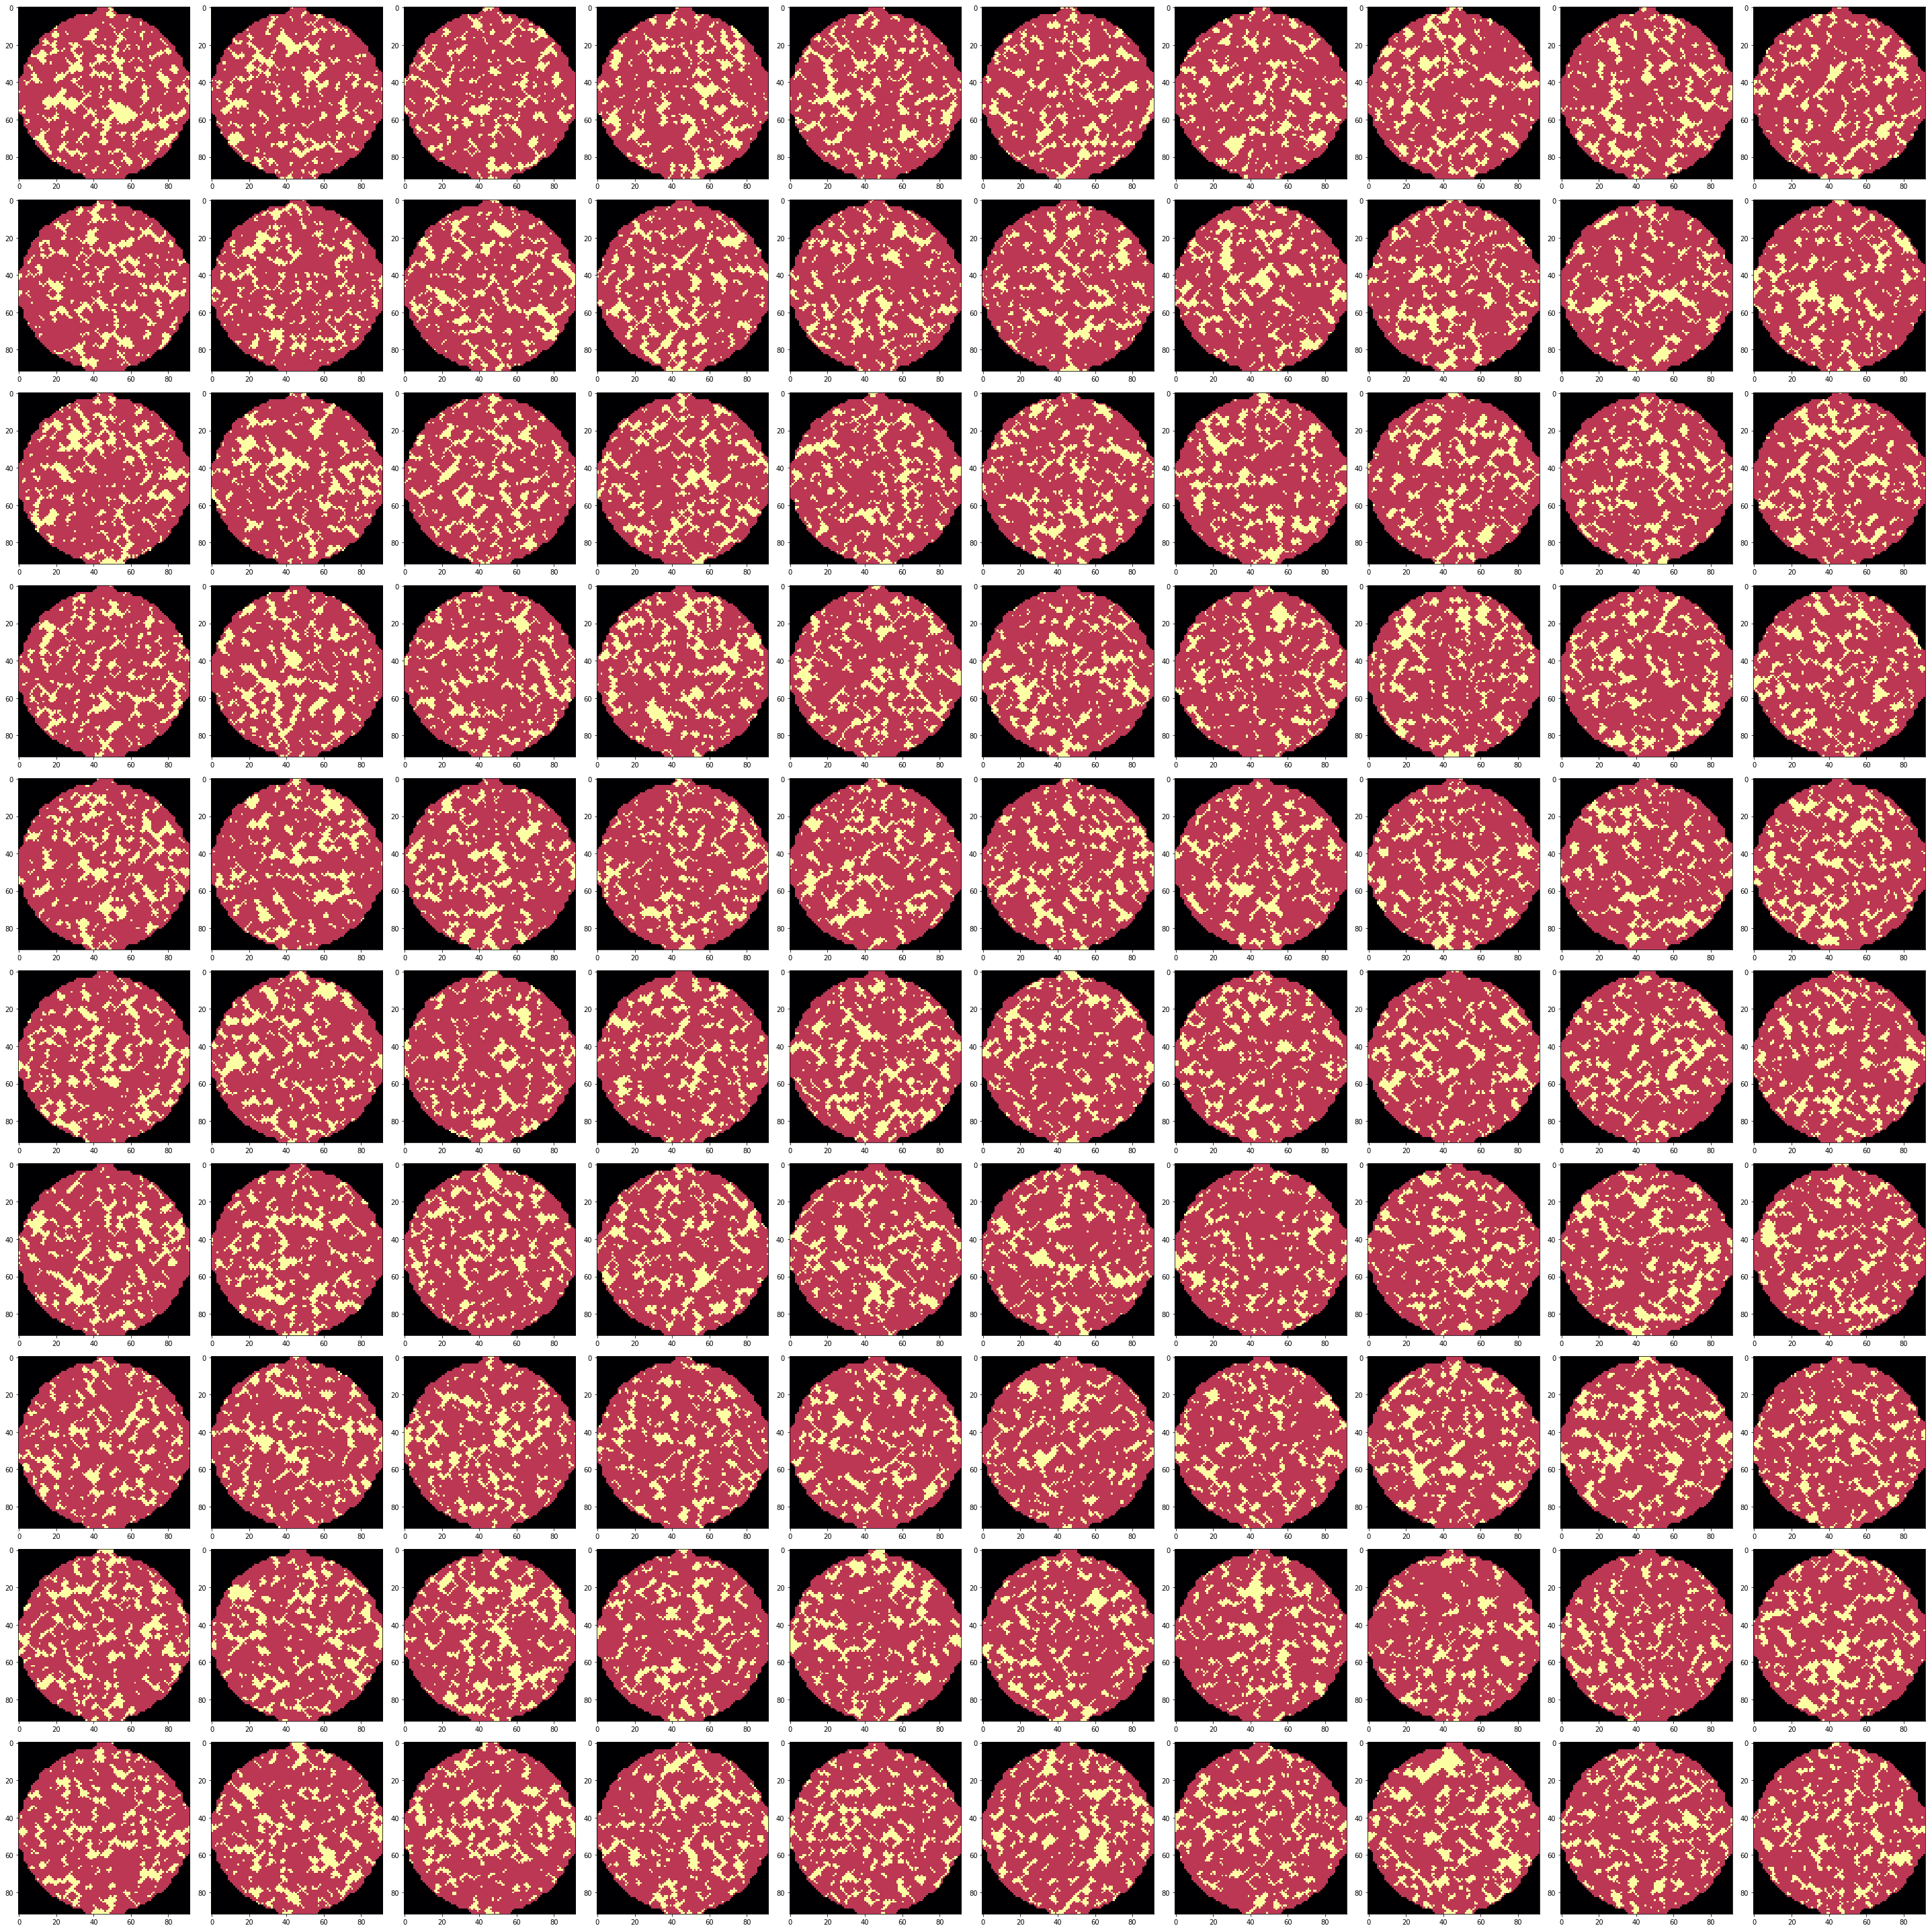

In [27]:
plot_random(100, lam_poisson=2)